# Libraries

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as Disp
from ipywidgets import widgets
import utils
import numpy as np

from scipy.spatial import ConvexHull

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
    
import keract
import networkx as nx
from collections import deque, defaultdict
import sklearn
from sklearn import preprocessing
from typing import TypedDict, Optional, Union
from pprint import pprint
from grandalf.layouts import SugiyamaLayout
import grandalf
from PIL import Image

from pathlib import Path
import seaborn as sns
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr

from nltk.corpus import wordnet as wn

from PIL import Image, ImageDraw
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE

/tmp/ipykernel_332737/2803614826.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-01 11:36:22.584707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 11:36:22.584733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 11:36:22.585602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

GPU is Enabled


# Datasets

2024-02-01 08:48:27.833962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 08:48:27.834196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 08:48:27.834429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

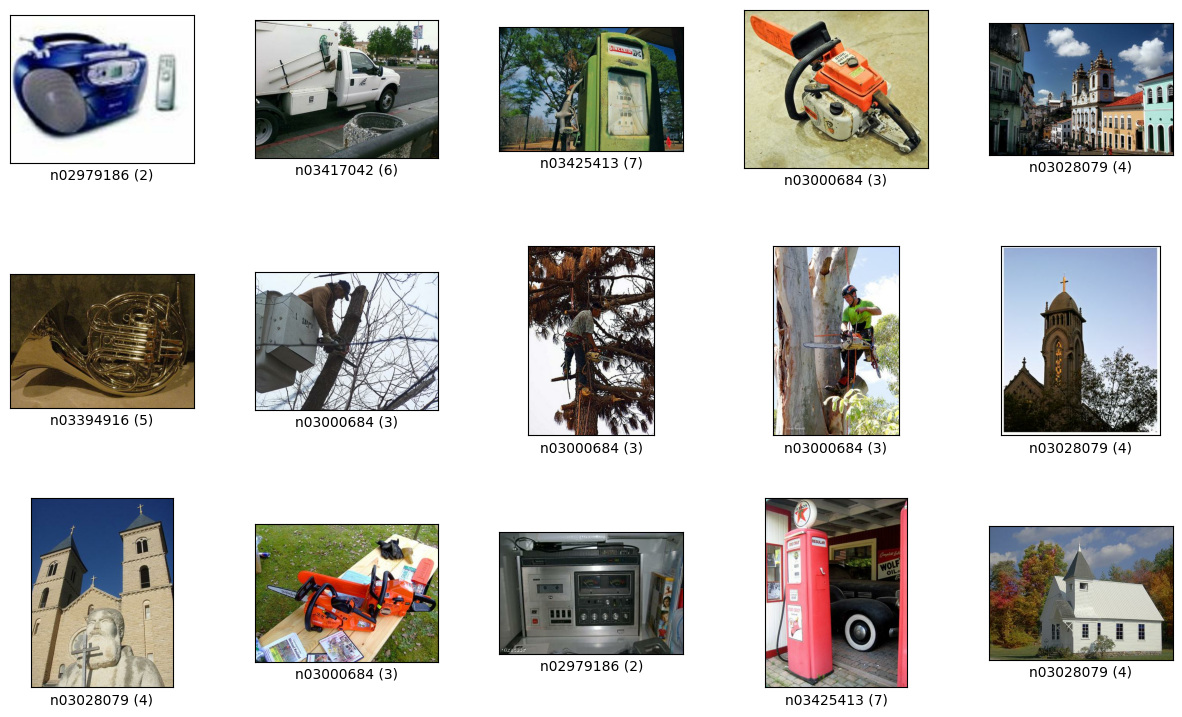

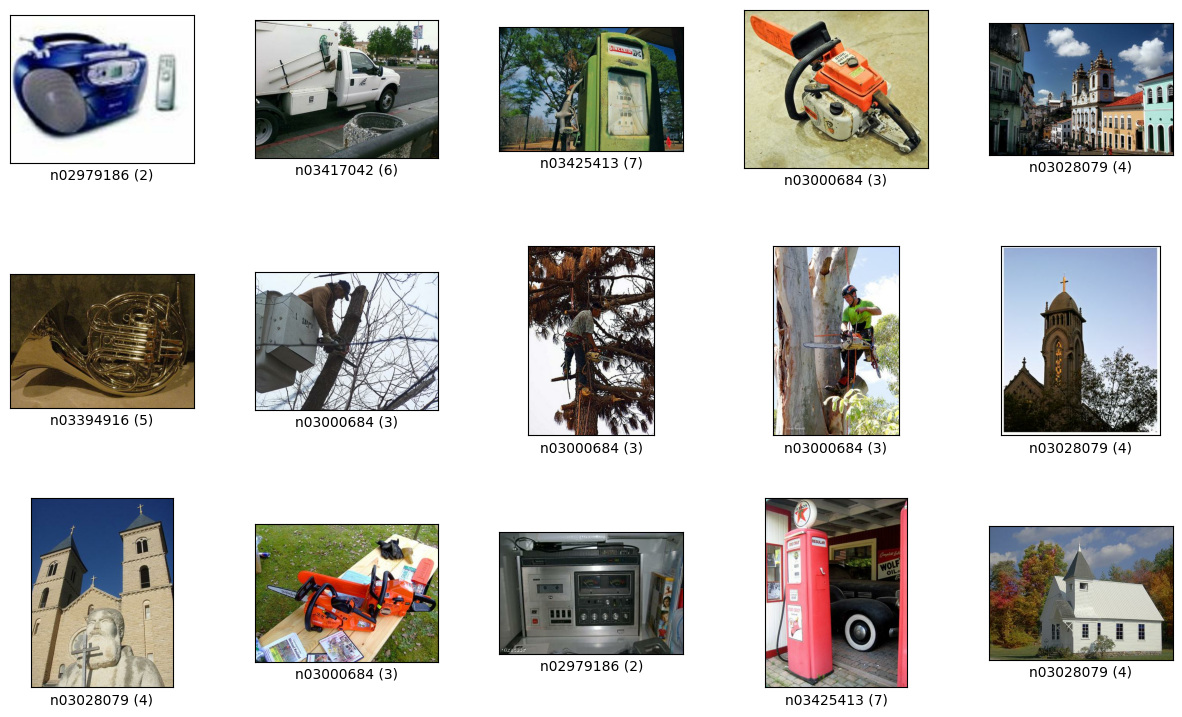

In [2]:
imagenette, imagenette_info = tfds.load(
    'imagenette/320px-v2',
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
    batch_size=None,
)
imagenette_labels = tfds.features.ClassLabel(
    names=list(map(lambda l: wn.synset_from_pos_and_offset(
        l[0], int(l[1:])).name(), imagenette_info.features['label'].names))
)

tfds.show_examples(imagenette['train'], imagenette_info, cols=5)

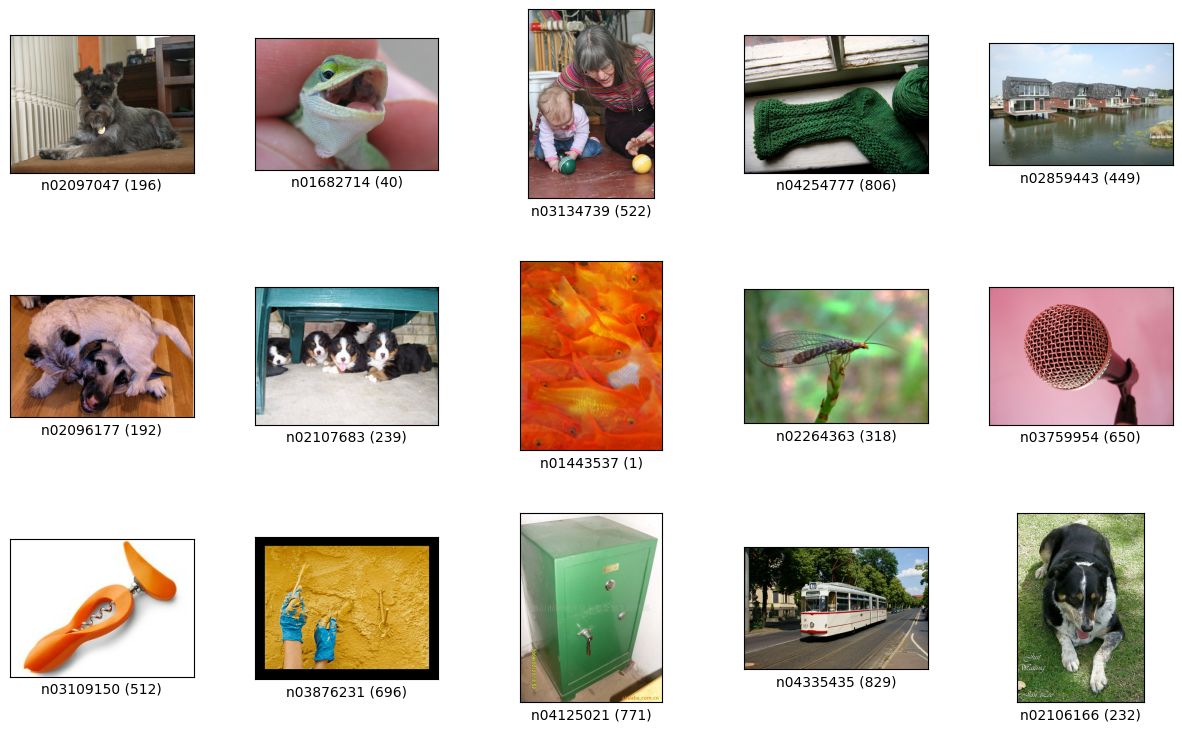

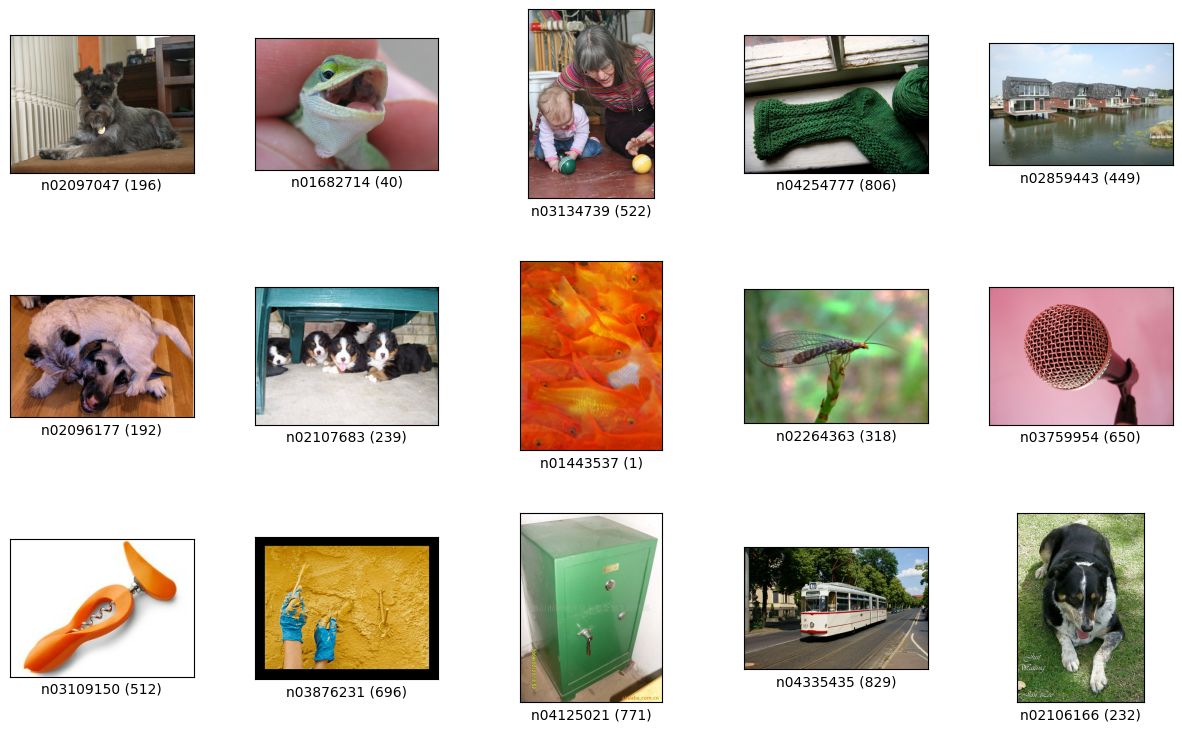

In [3]:
imagenet, imagenet_info = tfds.load(
    'imagenet2012',
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/SSD Games/Tensorflow/tensorflow_datasets'
)
imagenet_labels = tfds.features.ClassLabel(
    names=list(map(lambda l: wn.synset_from_pos_and_offset(
        l[0], int(l[1:])).name(), imagenet_info.features['label'].names))
)

tfds.show_examples(imagenet['train'], imagenet_info, cols=5)

2024-02-01 08:48:31.648594: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/insane/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-02-01 08:48:34.334310: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


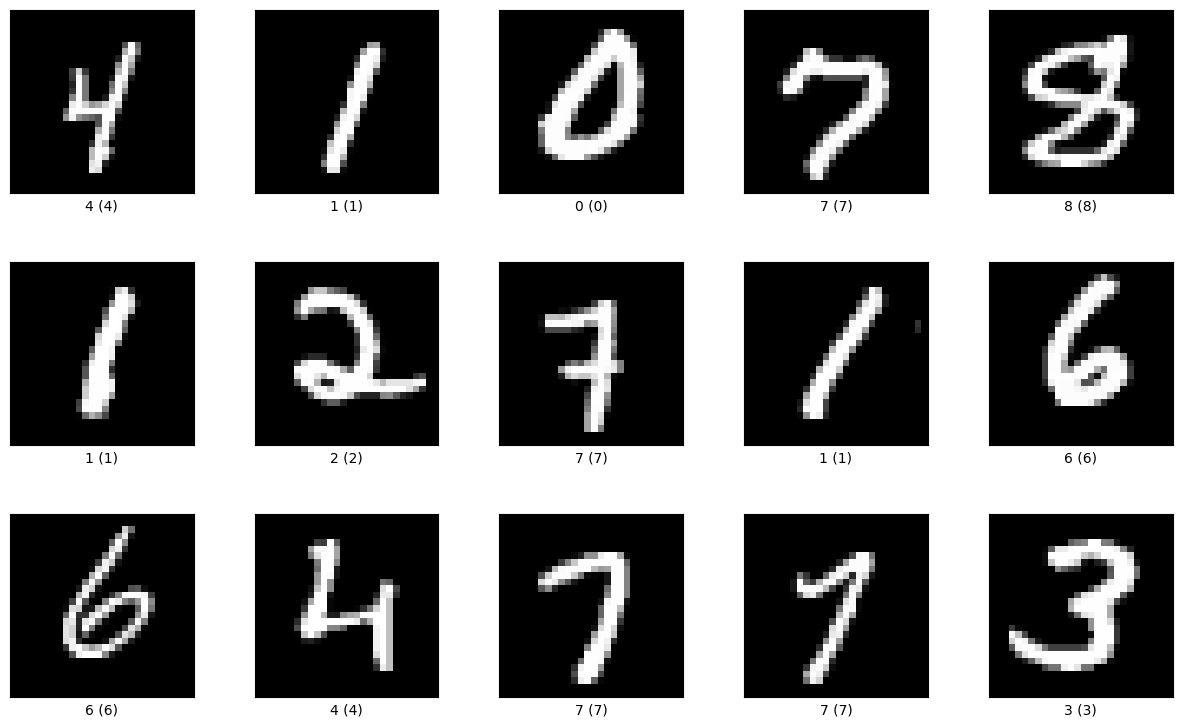

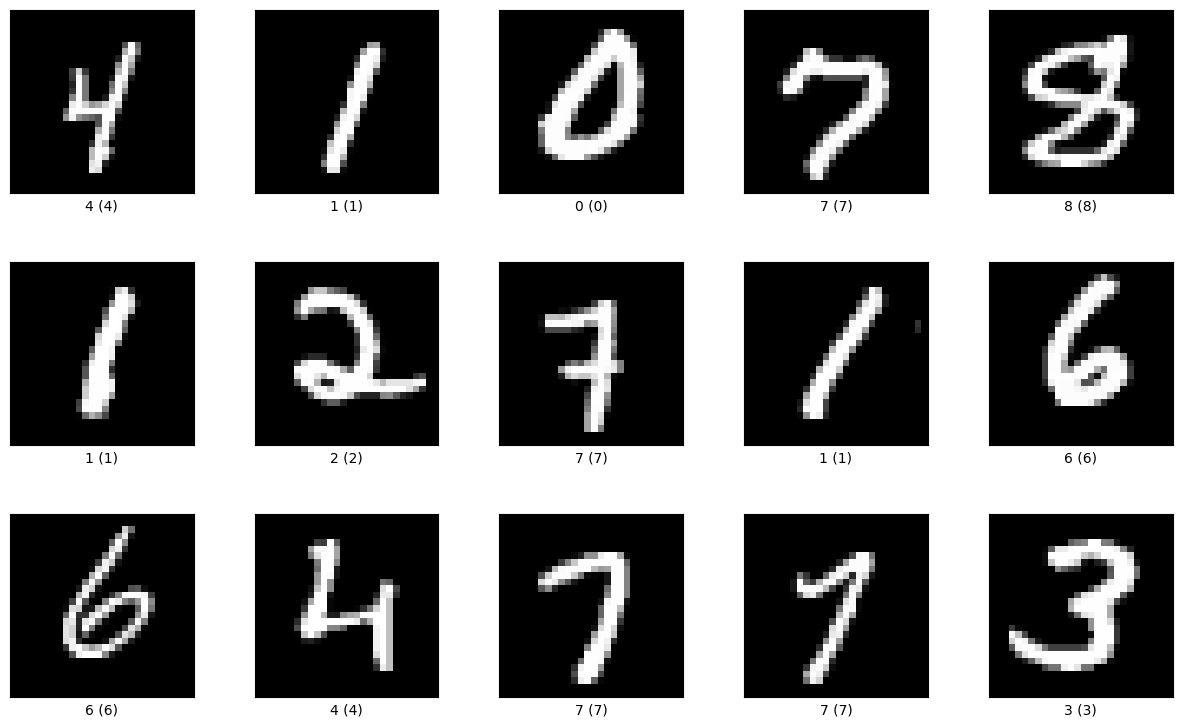

In [4]:
mnist, mnist_info = tfds.load(
    'mnist',
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
    batch_size=None,
)
mnist_labels = tfds.features.ClassLabel(names=list(map(str, range(10))))

tfds.show_examples(mnist['train'], mnist_info, cols=5)

In [5]:
fer2023 = tf.keras.utils.image_dataset_from_directory(
    '/home/insane/u/AffectiveTDA/FER-2013/train',
    seed=123,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=None,
)
fer2023_info = None
fer2023_labels = tfds.features.ClassLabel(names=fer2023.class_names)

# Draw grid to show samples images

NotFoundError: Could not find directory /home/insane/u/AffectiveTDA/FER-2013/train

In [ ]:
ds = imagenet['train']
ds_info = imagenet_info
label_names = imagenet_labels.names

# Models

In [3]:
inception_input_shape = tf.keras.applications.inception_v3.InceptionV3().input.shape[1:3].as_list()
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)
inception_v3.compile(loss="categorical_crossentropy", optimizer="adam")
@tf.function
def inception_preprocess(x, y):
    x = tf.image.resize(x, inception_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x, y

def inception_preprocess_inv(x, y):
    x = ((x / 2 + 0.5) * 255).astype(np.uint8).squeeze()
    return x, y

vgg16_input_shape = tf.keras.applications.vgg16.VGG16().input.shape[1:3].as_list()
vgg = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)
vgg.compile(loss="categorical_crossentropy", optimizer="adam")
@tf.function
def vgg16_preprocess(x, y):
    x = tf.image.resize(x, vgg16_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x, y
def vgg16_preprocess_inv(x, y):
    x = x.copy()
    if len(x.shape) == 4:
       x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                                 "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x, y

model = vgg
preprocess = vgg16_preprocess


2024-02-01 11:36:29.330206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 11:36:29.330405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 11:36:29.330559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

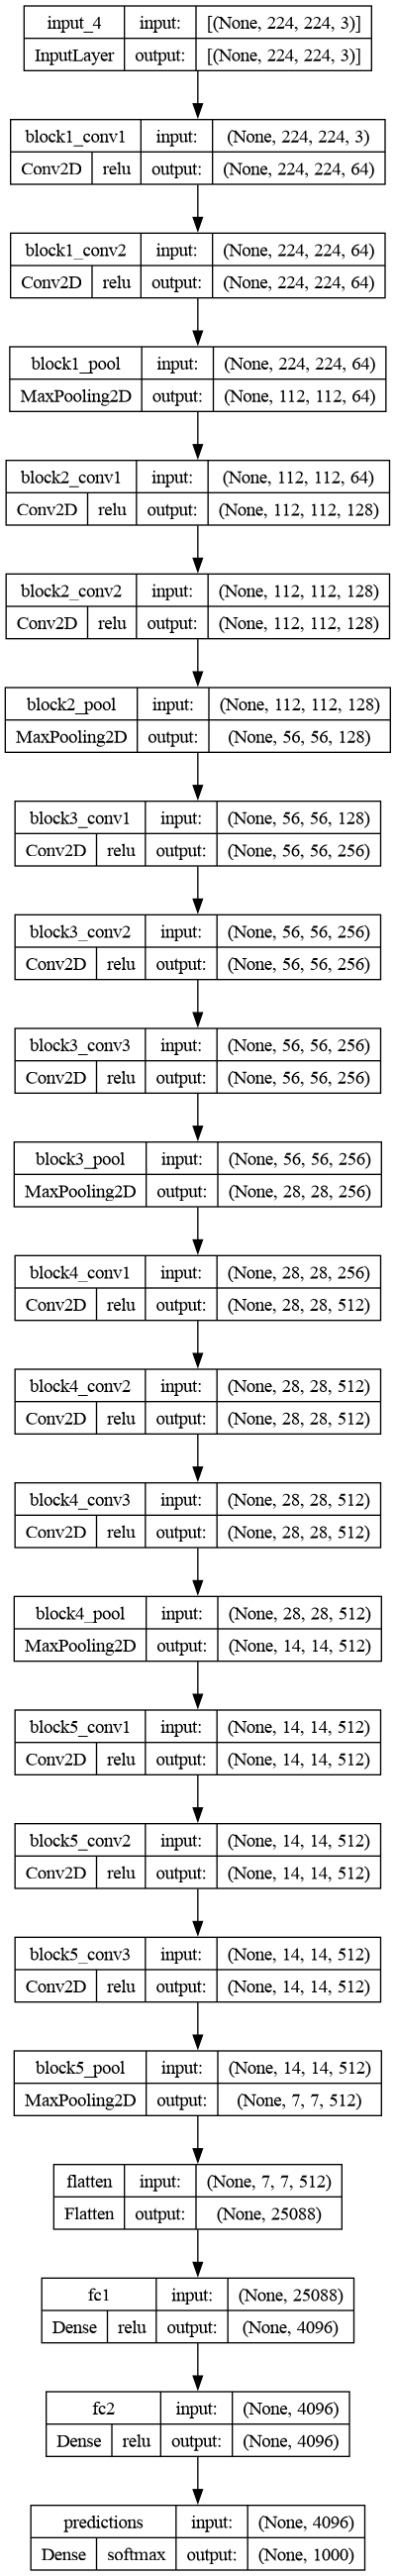

In [3]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True,
    # show_dtype=True,
    # expand_nested=True,
    show_layer_activations=True
)

# Get Activation Pathways

In [4]:
activation_pathway_full = utils.model_to_graph(model)
simple_activation_pathway_full = utils.remove_intermediate_node(
    activation_pathway_full, lambda node: activation_pathway_full.nodes[node]['layer_type'] not in ['Conv2D', 'Dense', 'InputLayer', 'Concatenate'])

In [43]:
def summary_fn_image(x):
    return np.linalg.norm(x, axis=tuple(range(1, len(x.shape)-1)), ord=2)

# def summary_fn_image(x):
#     threshold = np.median(x, axis=tuple(range(1, len(x.shape)-1))) 
#     return (x > threshold).sum(axis=tuple(range(1, len(x.shape)-1)))

# def summary_fn_image(x):
#     threshold = np.mean(x, axis=tuple(range(1, len(x.shape)-1)))
#     return (x > threshold).sum(axis=tuple(range(1, len(x.shape)-1)))

# OTSU Threshold
# def summary_fn_image(x):
#     bins_num = x.shape[1] * x.shape[2]
#     batch_thresholds = []
#     for batch in x:
#         thresholds = []
#         for img in batch.transpose(2, 0, 1):
#             hist, bin_edges = np.histogram(img, bins=bins_num)
#             bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
            
#             weight1 = np.cumsum(hist)
#             weight2 = np.cumsum(hist[::-1])[::-1]
#             # Get the class means mu0(t)
#             mean1 = np.cumsum(hist * bin_mids) / weight1
#             # Get the class means mu1(t)
#             mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
             
#             inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
             
#             # Maximize the inter_class_variance function val
#             index_of_max_val = np.argmax(inter_class_variance)
             
#             threshold = bin_mids[:-1][index_of_max_val]
#             thresholds.append(threshold)
#         batch_thresholds.append(thresholds)
    
#     batch_thresholds = np.array(batch_thresholds)
#     return (x > batch_thresholds).sum(axis=tuple(range(1, len(x.shape)-1)))


def summary_fn_dense(x): return x

In [11]:
labels=[0, 1, 10, 11]
examplePerClass = 2
shuffle = False

shuffled = shuffle
selectedLabels = labels

layers = list(map(lambda l: l.name, filter(lambda l: isinstance(l, (
    # tf.keras.layers.InputLayer,
    tf.keras.layers.Conv2D,
    tf.keras.layers.Dense,
    tf.keras.layers.Flatten,
    tf.keras.layers.Concatenate,
)), model.layers)))

datasetImgs = [[] for _ in range(len(labels))]
activations = [[] for _ in range(len(labels))]
activationsSummary = [[] for _ in range(len(labels))]
datasetLabels = [[] for _ in range(len(labels))]

@tf.function
def filter_by_labels(img, label):
    return tf.reduce_any(tf.equal(label, labels))
    
for img, label in tqdm(
utils.shuffle_or_noshuffle(ds, shuffle=shuffled
).filter(filter_by_labels
).map(preprocess
).batch(1
), total=examplePerClass*len(labels)):

    if len(datasetImgs[labels.index(label)]) >= examplePerClass:
        continue

    label_idx = labels.index(label)

    # Get activations
    activation = keract.get_activations(
        model, img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

    datasetImgs[label_idx].append(img.numpy())
    activations[label_idx].append(activation)

    activationSummary = {}
    for k, v in activation.items():
        if len(v[0].shape) == 1:
            # dense layer
            activationSummary[k] = summary_fn_dense(v)[0]
        elif len(v[0].shape) == 3:
            # Image layer
            activationSummary[k] = summary_fn_image(v)[0]
    activationsSummary[label_idx].append(activationSummary)

    datasetLabels[label_idx].append(label.numpy()[0].item())

    if all((len(dtImgs) >= examplePerClass) for dtImgs in datasetImgs):
        break

datasetImgs = [j for i in datasetImgs for j in i]
activations = [j for i in activations for j in i]
activationsSummary = [j for i in activationsSummary for j in i]
datasetLabels = [j for i in datasetLabels for j in i]

# Get the prediction with argmax
predictions = []
for i in range(len(activations)):
    predictions.append(np.argmax(activations[i][layers[-1]][0]).item())

  0%|          | 0/8 [00:00<?, ?it/s]2023-06-05 14:03:14.069868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1024]
	 [[{{node Placeholder/_1}}]]
2023-06-05 14:03:14.070083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1024]
	 [[{{node Placeholder/_4}}]]
9it [00:11,  1.29s/it]                       


# Individual Input

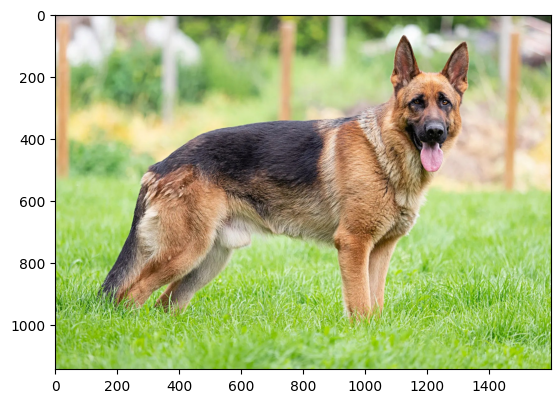

In [5]:
orig_input_img = Image.open("dog.jpg")
orig_input_img = np.array(orig_input_img)

def vgg16_preprocess(x, y):
    x = tf.image.resize(x, vgg16_input_shape, method=tf.image.ResizeMethod.BILINEAR).numpy()
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x, y

preprocess = vgg16_preprocess
input_img, label = preprocess(orig_input_img, None)

plt.imshow(orig_input_img)

In [63]:
pred = model(np.array([input_img]))

layers = list(map(lambda l: l.name, filter(lambda l: isinstance(l, (
    # tf.keras.layers.InputLayer,
    tf.keras.layers.Conv2D,
    tf.keras.layers.Dense,
    tf.keras.layers.Flatten,
    tf.keras.layers.Concatenate,
)), model.layers)))

activations = keract.get_activations(
    model, np.array([input_img]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

# Save all the activations as images in corresponding folders inside the activations folder
Path("activations").mkdir(exist_ok=True)
for layer, act in activations.items():
    Path(f"activations/{layer}").mkdir(exist_ok=True)
    if len(act[0].shape) == 3:
        for i in range(act[0].shape[-1]):
            norm_act = (act[0][:, :, i] - act[0][:, :, i].min()) / (act[0][:, :, i].max() - act[0][:, :, i].min())
            orig_input_img_norm = (orig_input_img - orig_input_img.min()) / (orig_input_img.max() - orig_input_img.min())
            plt.imsave(f"activations/{layer}/{i}.png", norm_act, cmap='gray')
            overlay = utils.get_activation_overlay(
                orig_input_img_norm,
                norm_act,
                alpha=0.6
            )
            # save the overlay in {layer}_overlays folder
            Path(f"activations/{layer}_overlays").mkdir(exist_ok=True)
            plt.imsave(f"activations/{layer}_overlays/{i}.png", overlay, cmap='gray')
    elif len(act[0].shape) == 1:
        plt.imsave(f"activations/{layer}.png", act[0][:, None], cmap='gray')


activationsSummary = {}
for k, v in activations.items():
    if len(v[0].shape) == 1:
        # dense layer
        activationsSummary[k] = summary_fn_dense(v)[0]
    elif len(v[0].shape) == 3:
        # Image layer
        activationsSummary[k] = summary_fn_image(v)[0]

print('Predicted', label_names[tf.math.argmax(pred[0]).numpy()])
print('True Cat')

/tmp/ipykernel_288093/1029402504.py:20: RuntimeWarning: invalid value encountered in divide
  norm_act = (act[0][:, :, i] - act[0][:, :, i].min()) / (act[0][:, :, i].max() - act[0][:, :, i].min())


NameError: name 'label_names' is not defined

In [8]:
# save the red green blue channels of the original image as red green and blue images, not using cmap gray because they should be red, green and blue colors images
Path("activations/original").mkdir(exist_ok=True)
for i in ['red', 'green', 'blue']:
    # get the channel
    channel = orig_input_img[:, :, ['red', 'green', 'blue'].index(i)]
    # normalize the channel
    channel = (channel - channel.min()) / (channel.max() - channel.min())
    # Add two other channels with zeros 0 for red, 1 for green and 2 for blue
    lower_int = 1
    if i == 'red':
        channel = np.stack([np.zeros_like(channel), channel*lower_int, np.zeros_like(channel)], axis=-1)
    elif i == 'green':
        channel = np.stack([np.zeros_like(channel), np.zeros_like(channel), channel*lower_int], axis=-1)
    elif i == 'blue':
        channel = np.stack([channel*lower_int, np.zeros_like(channel), np.zeros_like(channel)], axis=-1)

    # save the channel
    plt.imsave(f"activations/original/{i}.png", channel)

In [ ]:
layer

In [ ]:
for k, v in activationsSummary.items():
    print(k, v)

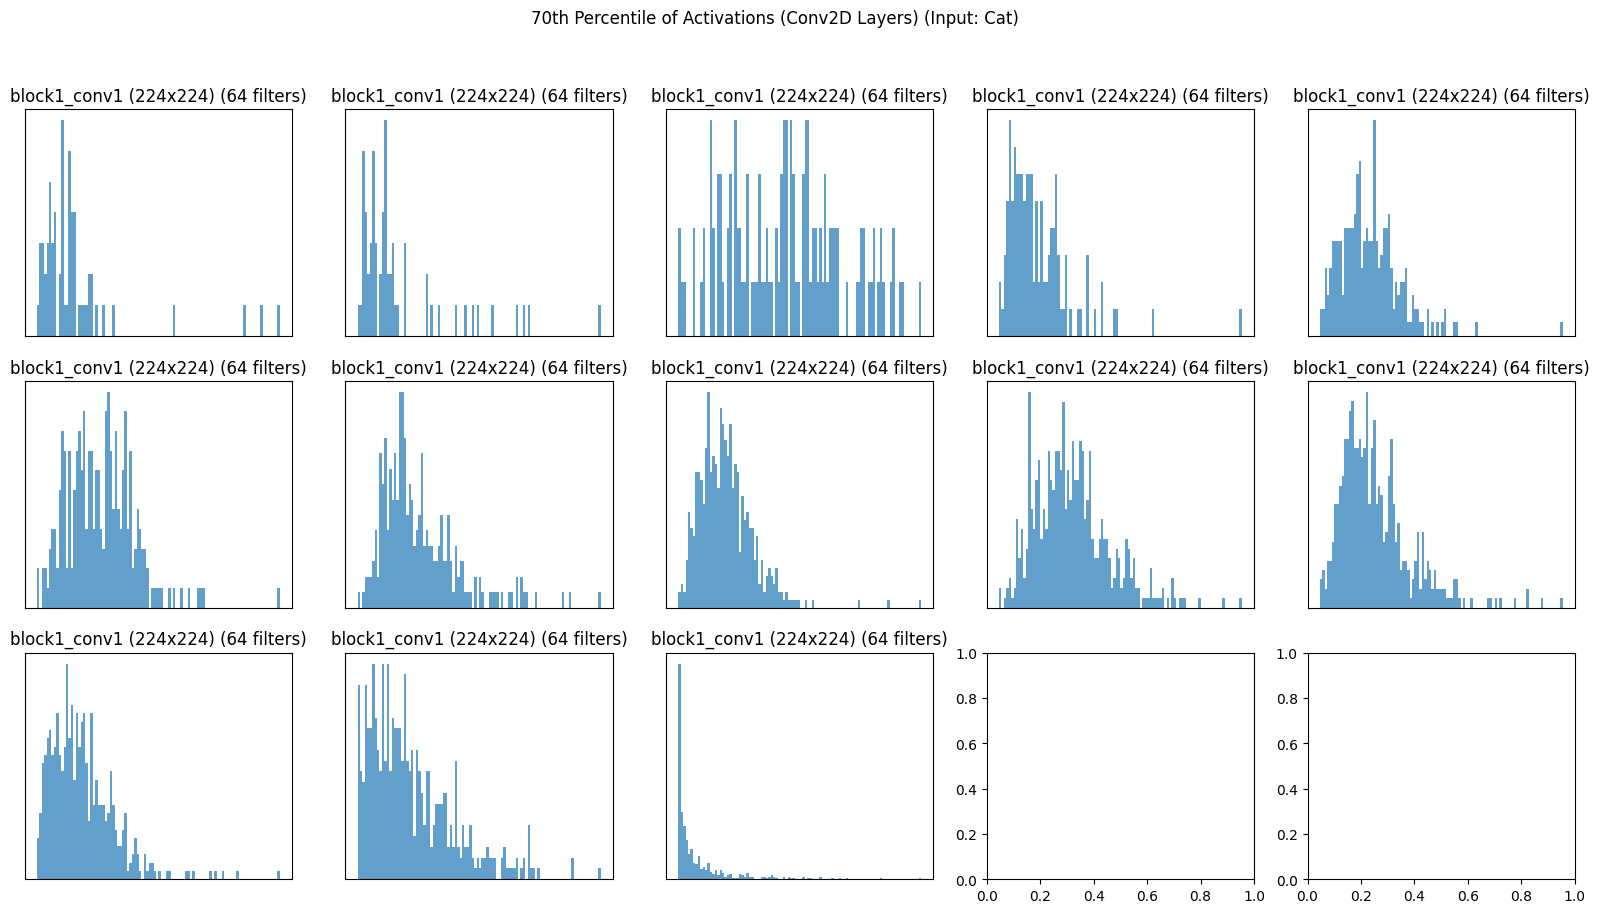

In [52]:
label = 0
examplePerClass = 1
label = 0
conv2D_activations = [layer for layer in activationsSummary if 'conv' in layer]
layer = 'block1_conv1'

cols = 5
rows = len(conv2D_activations) // cols + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10),
    # sharex=True,
    # sharey=True
)
axes = axes.flatten()
fig.suptitle("70th Percentile of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Mean of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Median of Activations (Conv2D Layers) (Input: Cat)")

for summary, ax in zip(conv2D_activations, axes):
    ax.hist(activationsSummary[summary], bins=100, alpha=0.7)
    ax.set_title(f"{layer} ({activations[layer].shape[1]}x{activations[layer].shape[2]}) ({activations[layer].shape[3]} filters)")

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [30]:
layer = 'block5_conv2'
label = 0
nrows = 8
cur_activations = np.abs(activations[label*examplePerClass][layer])
cur_activations = (cur_activations - np.percentile(cur_activations, 10)) / (np.percentile(cur_activations, 90) - np.percentile(cur_activations, 10))
cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)

# Plot all the images from layer in grid with nrows columns
fig, ax = plt.subplots(figsize=(60, 60))
for i in range(cur_activations.shape[3]):
    ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)
    ax.imshow(
        cur_activations[0,:,:,i],
        interpolation='nearest',
        cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.show()


NameError: name 'activations' is not defined

block5_conv2 (1, 28, 28, 512) 


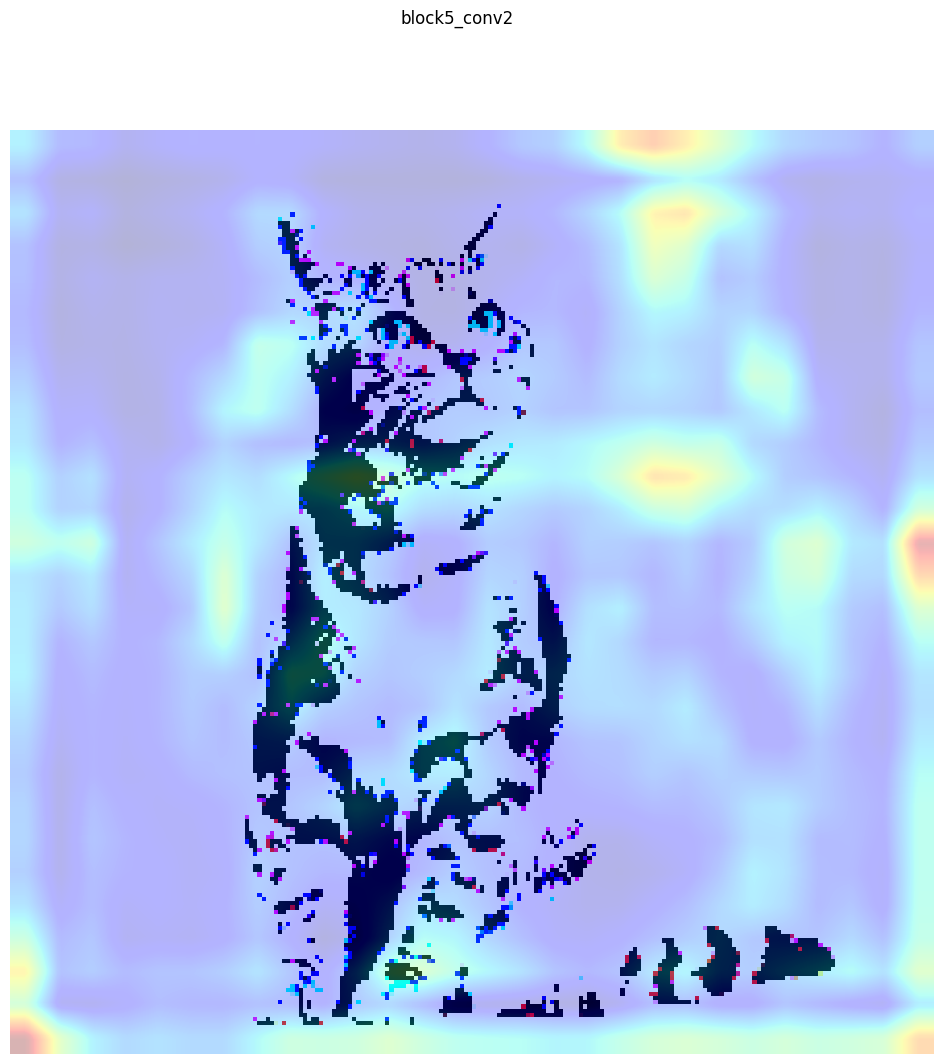

In [16]:
keract.display_heatmaps({layer: np.array([activations[0]['block4_conv3'][0]])}, input_img, fix=False, merge_filters=True)

# Filtering activation layers

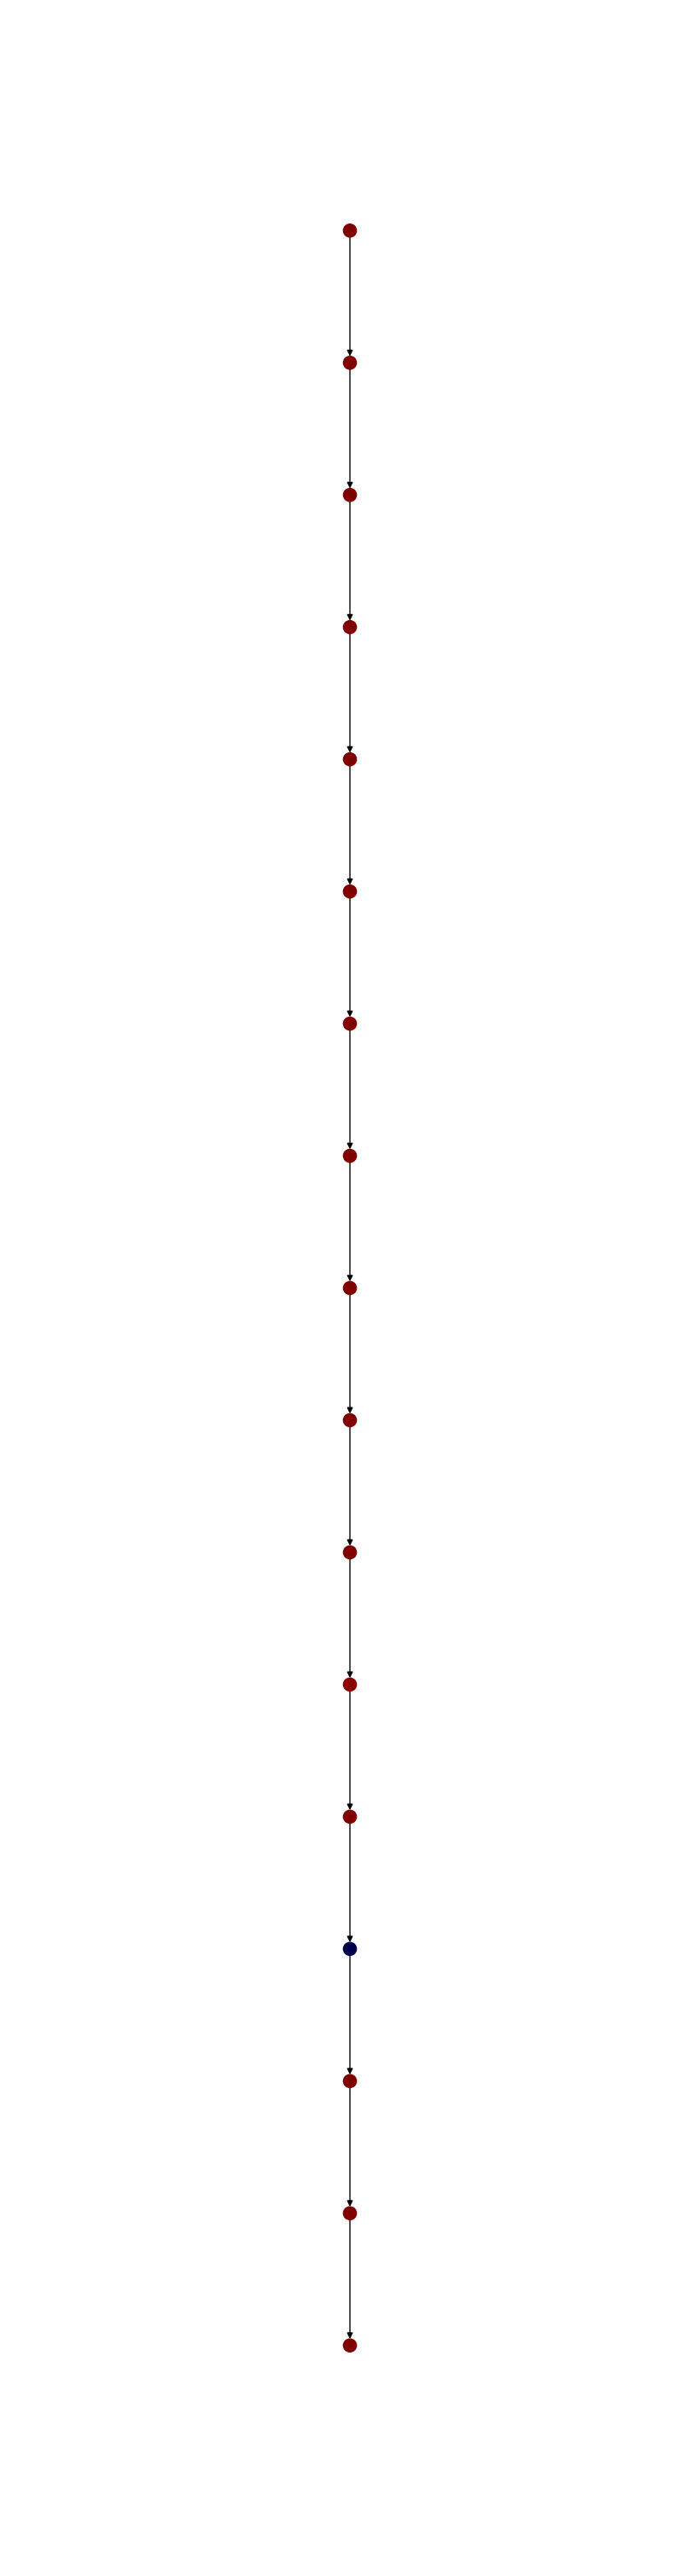

In [17]:
label = 0
THRESHOLD = 0.5
TOP_BOT_CUT = 0

simple_activation_pathway_full_img1 = simple_activation_pathway_full.copy()

for node, data in simple_activation_pathway_full_img1.nodes(data=True):
    if 'conv' in data['name'] or 'mixed' in data['name']:
        values = activationsSummary[label*examplePerClass][data['name']]
        dynamic_threshold = np.percentile(values, 100 * THRESHOLD)
        # values = values > dynamic_threshold
        values = values > THRESHOLD
        simple_activation_pathway_full_img1.nodes[node]['activated'] = values
    else:
        simple_activation_pathway_full_img1.nodes[node]['activated'] = np.array([True])


plt.figure(figsize=(8,30))
activated_count = np.array([data['activated'].sum()/len(data['activated']) for node, data in simple_activation_pathway_full_img1.nodes(data=True)])
activated_count = (activated_count - activated_count.min()) / (activated_count.max() - activated_count.min())

cmap = list(map(mpl.colormaps['seismic'], activated_count))
nx.draw(
    simple_activation_pathway_full_img1,
    pos=utils.get_model_layout(simple_activation_pathway_full_img1),
    node_size=120,
    node_color=cmap,
    # labels=nx.get_node_attributes(simple_activation_pathway_full_img1, 'name'),
    # connectionstyle="arc3,rad=0.1"
)
plt.show()

['input_4   1/1', 'block1_conv1   64/64', 'block1_conv2   64/64', 'block2_conv1   128/128', 'block2_conv2   128/128', 'block3_conv1   256/256', 'block3_conv2   256/256', 'block3_conv3   256/256', 'block4_conv1   512/512', 'block4_conv2   512/512', 'block4_conv3   512/512', 'block5_conv1   511/512', 'block5_conv2   512/512', 'block5_conv3   473/512', 'fc1   1/1', 'fc2   1/1', 'predictions   1/1']


/tmp/ipykernel_171113/2341248753.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


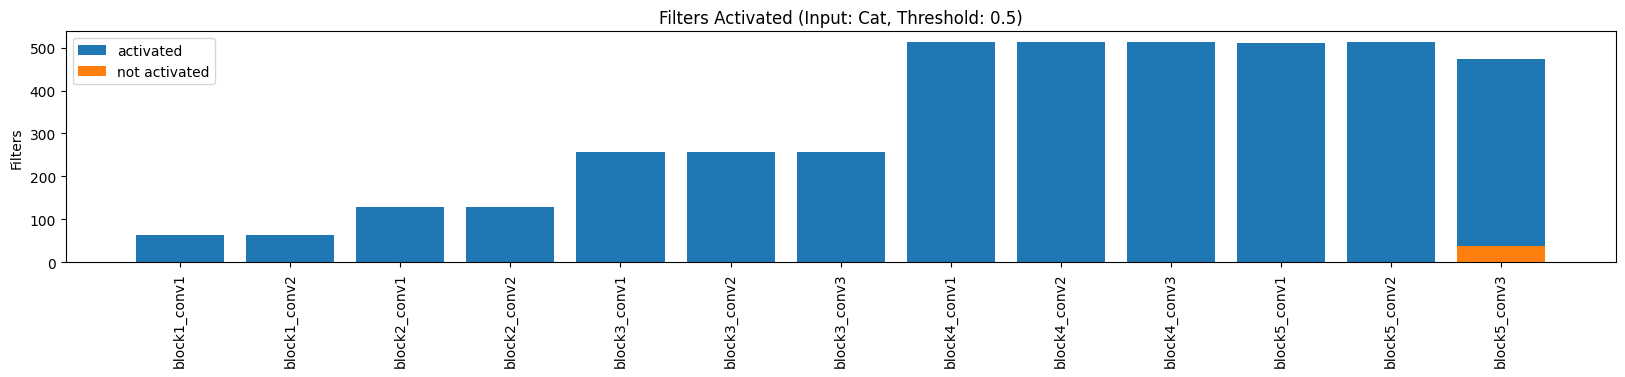

In [18]:
print([f"{data['name']}   {data['activated'].sum()}/{len(data['activated'])}" for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data])
activated = {data['name']: (data['activated'].sum(), len(data['activated'])-data['activated'].sum()) for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data}

conv2D_activated = {k: v for k, v in activated.items() if 'conv' in k}

labels = [k for k in conv2D_activated.keys()]
activated = [v[0] for v in conv2D_activated.values()]
deactivated = [v[1] for v in conv2D_activated.values()]

fig, ax = plt.subplots(figsize=(20, 3))
ax.bar(labels, activated, label="activated")
ax.bar(labels, deactivated, label="not activated")
ax.set_ylabel("Filters")
ax.set_xticklabels(labels, rotation=90)
ax.set_title(f"Filters Activated (Input: Cat, Threshold: {THRESHOLD})")
ax.legend()
plt.show()

2023-06-05 11:59:17.764636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1024]
	 [[{{node Placeholder/_1}}]]
2023-06-05 11:59:17.764879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1024]
	 [[{{node Placeholder/_2}}]]
2023-06-05 11:59:17.867053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1024

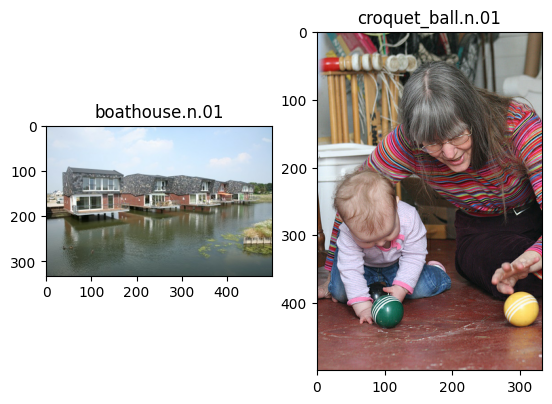

In [19]:
example_img1, example_label1 = utils.get_example(ds)
example_img2, example_label2 = utils.get_example(ds)
plt.subplot(121)
plt.title(label_names[example_label1])
plt.imshow(example_img1)
plt.subplot(122)
plt.imshow(example_img2)
plt.title(label_names[example_label2])
plt.show()

example_img1, _ = preprocess(example_img1, None)
example_img2, _ = preprocess(example_img2, None)

11727182.5859375


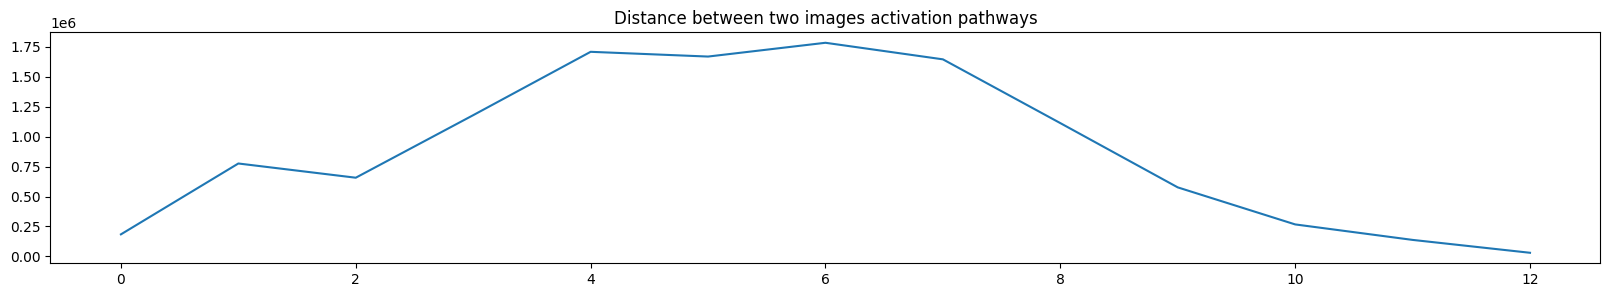

In [20]:
layers = None

activations1 = keract.get_activations(model, np.array([example_img1]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
activations2 = keract.get_activations(model, np.array([example_img2]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


dist = {f"{i_name}-{j_name}": utils.single_activation_distance(summary_fn_image(layer_i), summary_fn_image(layer_j)) for i_name, layer_i in activations1.items() for j_name, layer_j in activations2.items() if ('conv' in i_name or 'mixed' in i_name) and i_name == j_name}

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dist.values())
# ax.set_ylim(0, 10)
ax.set_title("Distance between two images activation pathways")
print(sum(dist.values()))

In [21]:
dist

{'block1_conv1-block1_conv1': 184334.72,
 'block1_conv2-block1_conv2': 775807.5,
 'block2_conv1-block2_conv1': 657152.0,
 'block2_conv2-block2_conv2': 1179179.1,
 'block3_conv1-block3_conv1': 1708135.5,
 'block3_conv2-block3_conv2': 1668536.8,
 'block3_conv3-block3_conv3': 1783549.9,
 'block4_conv1-block4_conv1': 1645294.0,
 'block4_conv2-block4_conv2': 1112962.2,
 'block4_conv3-block4_conv3': 576483.5,
 'block5_conv1-block5_conv1': 267254.6,
 'block5_conv2-block5_conv2': 137991.6,
 'block5_conv3-block5_conv3': 30501.18}

# Get summary for whole dataset

In [23]:
layers = list(filter(lambda l: 'conv' in l or 'mixed' in l, map(lambda l: l.name, model.layers)))

for img_batch, label_batch in ds.map(preprocess).batch(32):
    activations = keract.get_activations(model, img_batch, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
    print(activations[layers[0]].shape)
    print(summary_fn_image(activations[layers[0]]).shape)
    
    # pred = inception_v3.predict(img_batch)
    # print(np.sum(pred.argmax(axis=1) == label_batch.numpy()))
    break

2023-06-05 12:01:03.786315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 12:01:03.786519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1024]
	 [[{{node Placeholder/_2}}]]


(32, 224, 224, 64)
(32, 64)


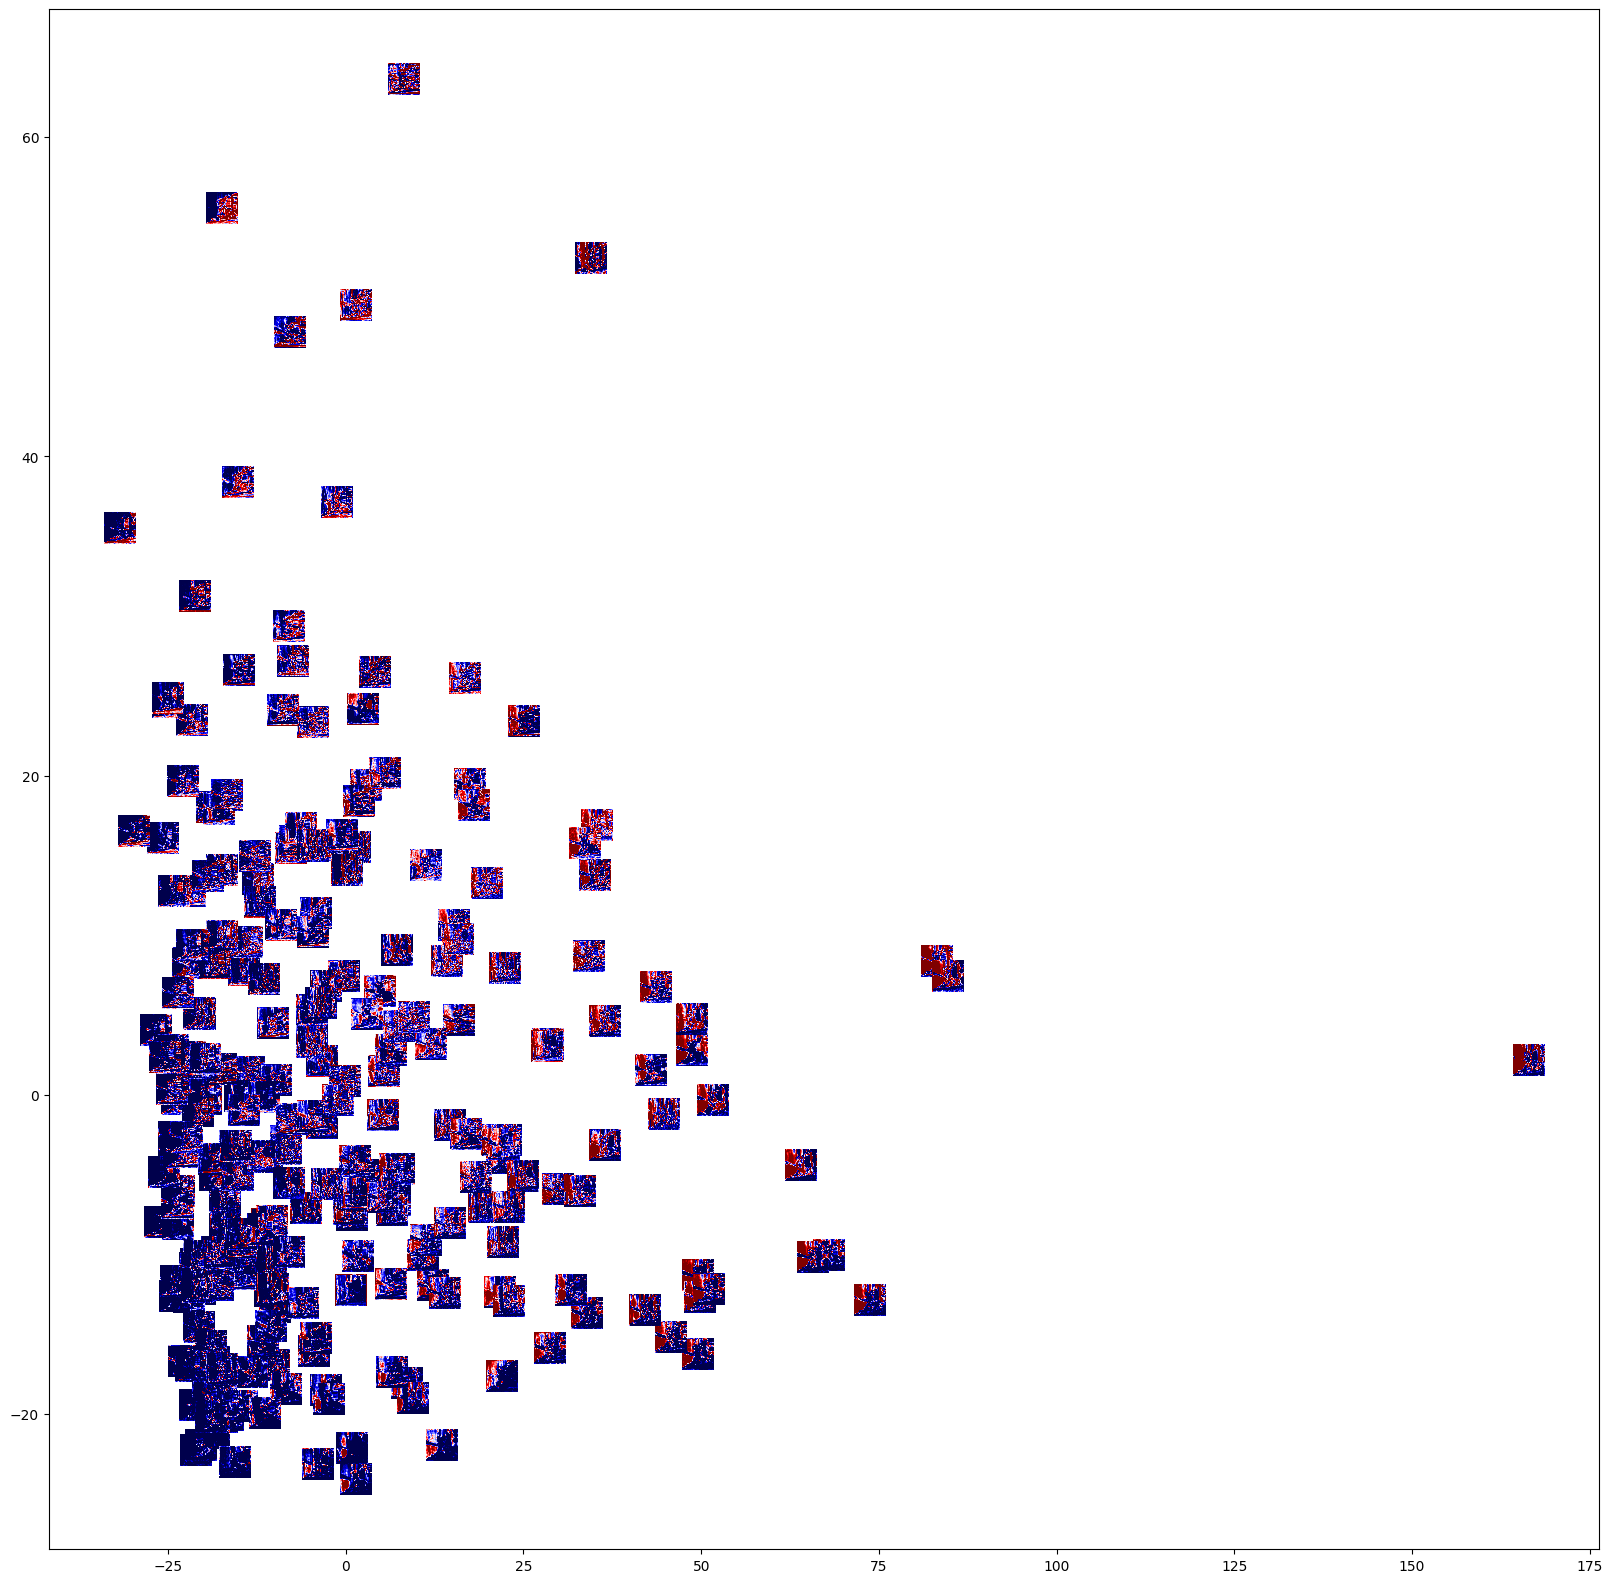

In [26]:
LOW_PERCENT = 10
HIGH_PERCENT = 90
img_size_zoom = 0.4
threshold = 7
thresholded = summary_fn_image(np.array([activations[layer][0]]))[0] > threshold

layer = 'block3_conv1'

data = np.moveaxis(activations[layer][0], 2, 0)
train = data.reshape((data.shape[0], -1))
train = StandardScaler().fit_transform(train)

pca = PCA(n_components=2)
pca_res = pca.fit_transform(train)
x = pca_res[:,0]
y = pca_res[:,1]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

0.0 7315.2314


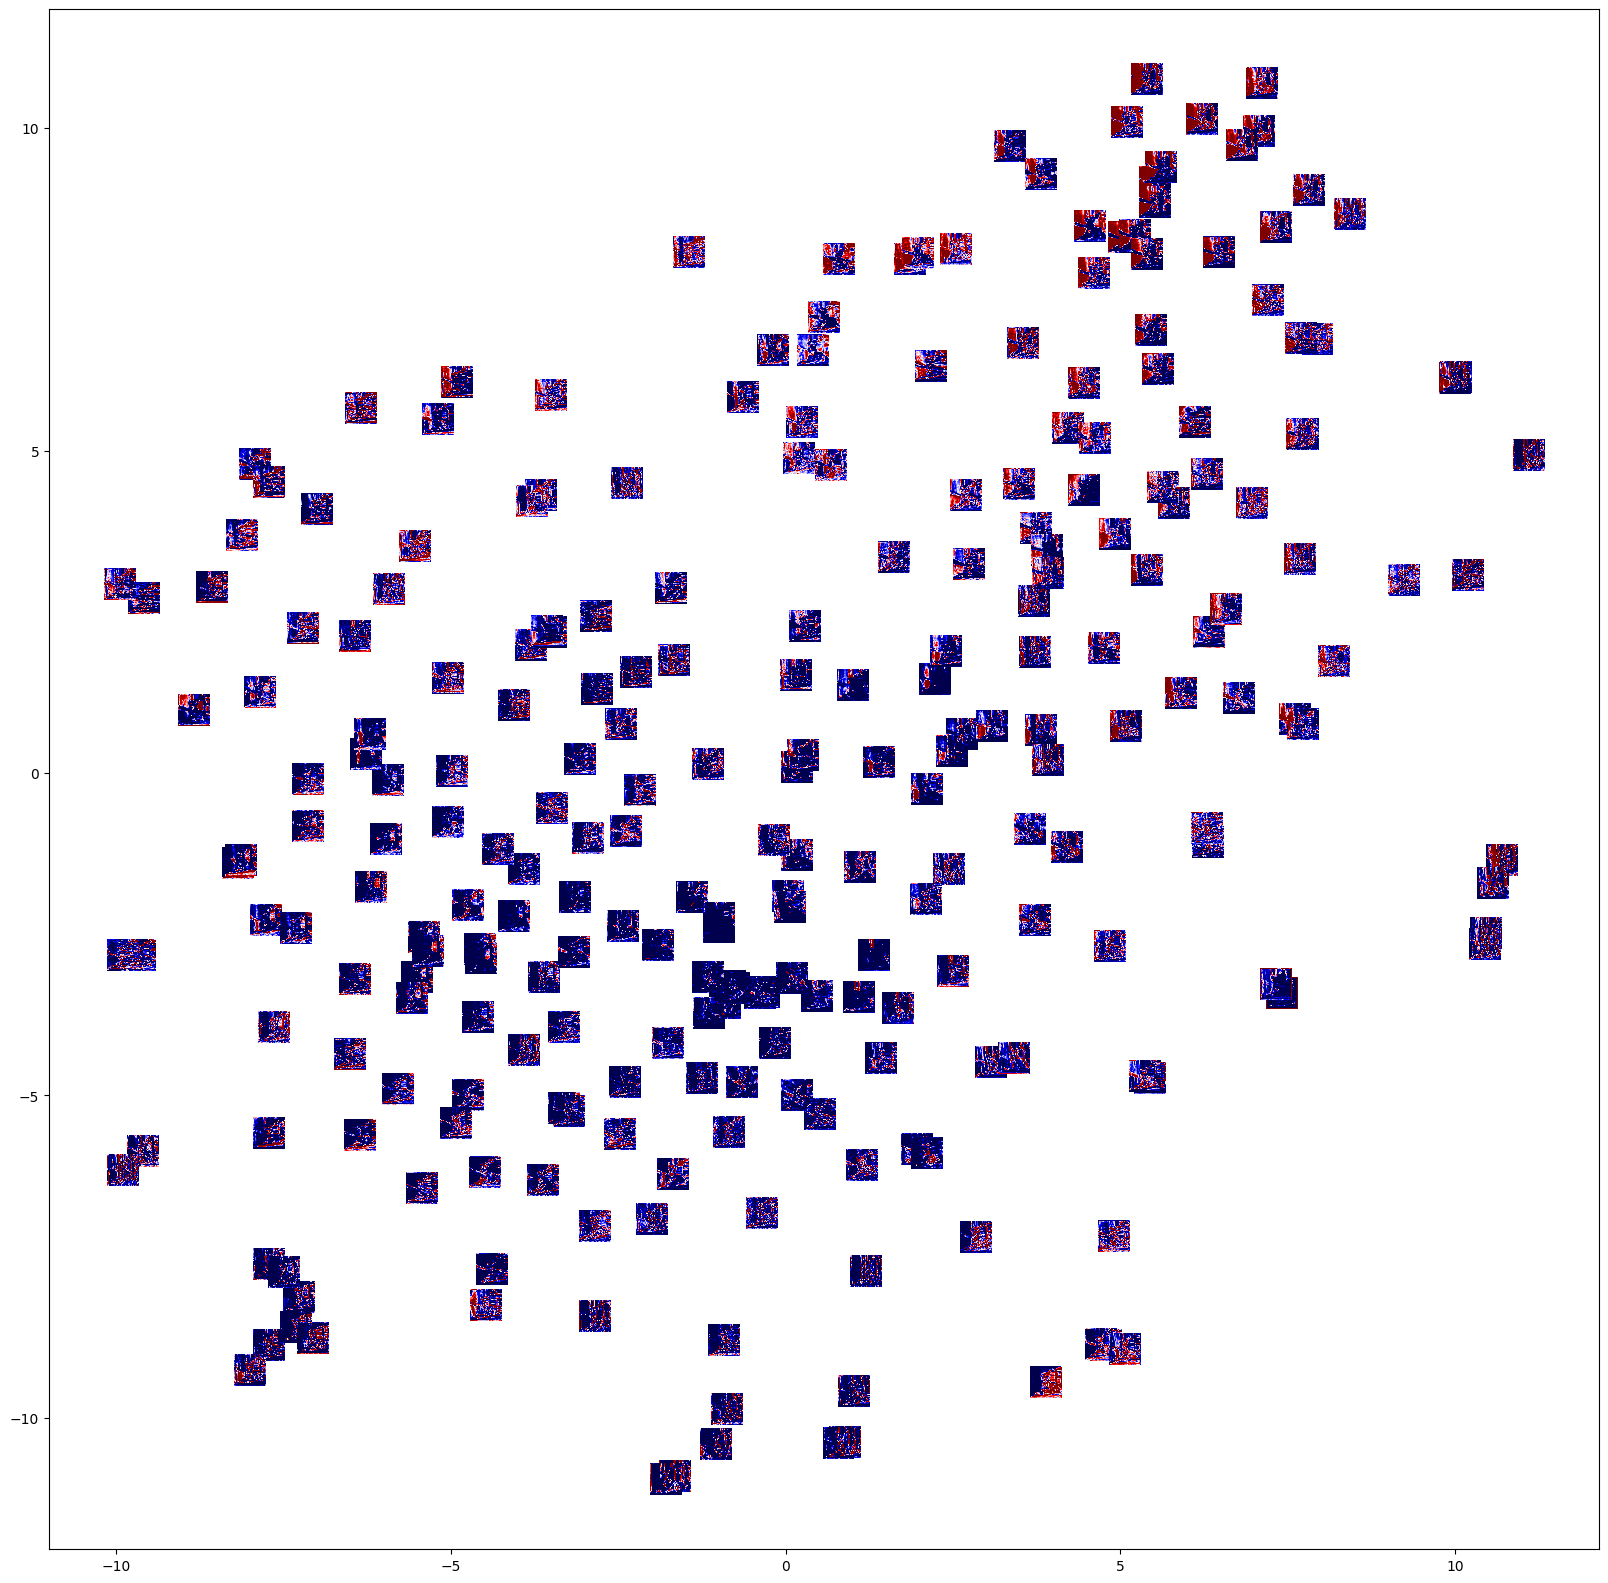

In [28]:
tsne = TSNE(n_components = 2, random_state=0, perplexity=30)
tsne_res = tsne.fit_transform(train)

x = tsne_res[:,0]
y = tsne_res[:,1]

print(data.min(), data.max())

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

In [29]:
# umap library is still not stable to flawlessy work on all environments
# import umap
# reducer = umap.UMAP(
#     n_neighbors=50
# )

# umap_res = reducer.fit_transform(train)

# x = umap_res[:,0]
# y = umap_res[:,1]

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.scatter(x, y) 

# for i, (x0, y0) in enumerate(zip(x, y)):
#     if not thresholded[i]:
#         continue
#     offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
#     img = offsetImg.get_children()[0]
#     img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
#     ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
#     ax.add_artist(ab)

# Activation Footprint

<Axes: >

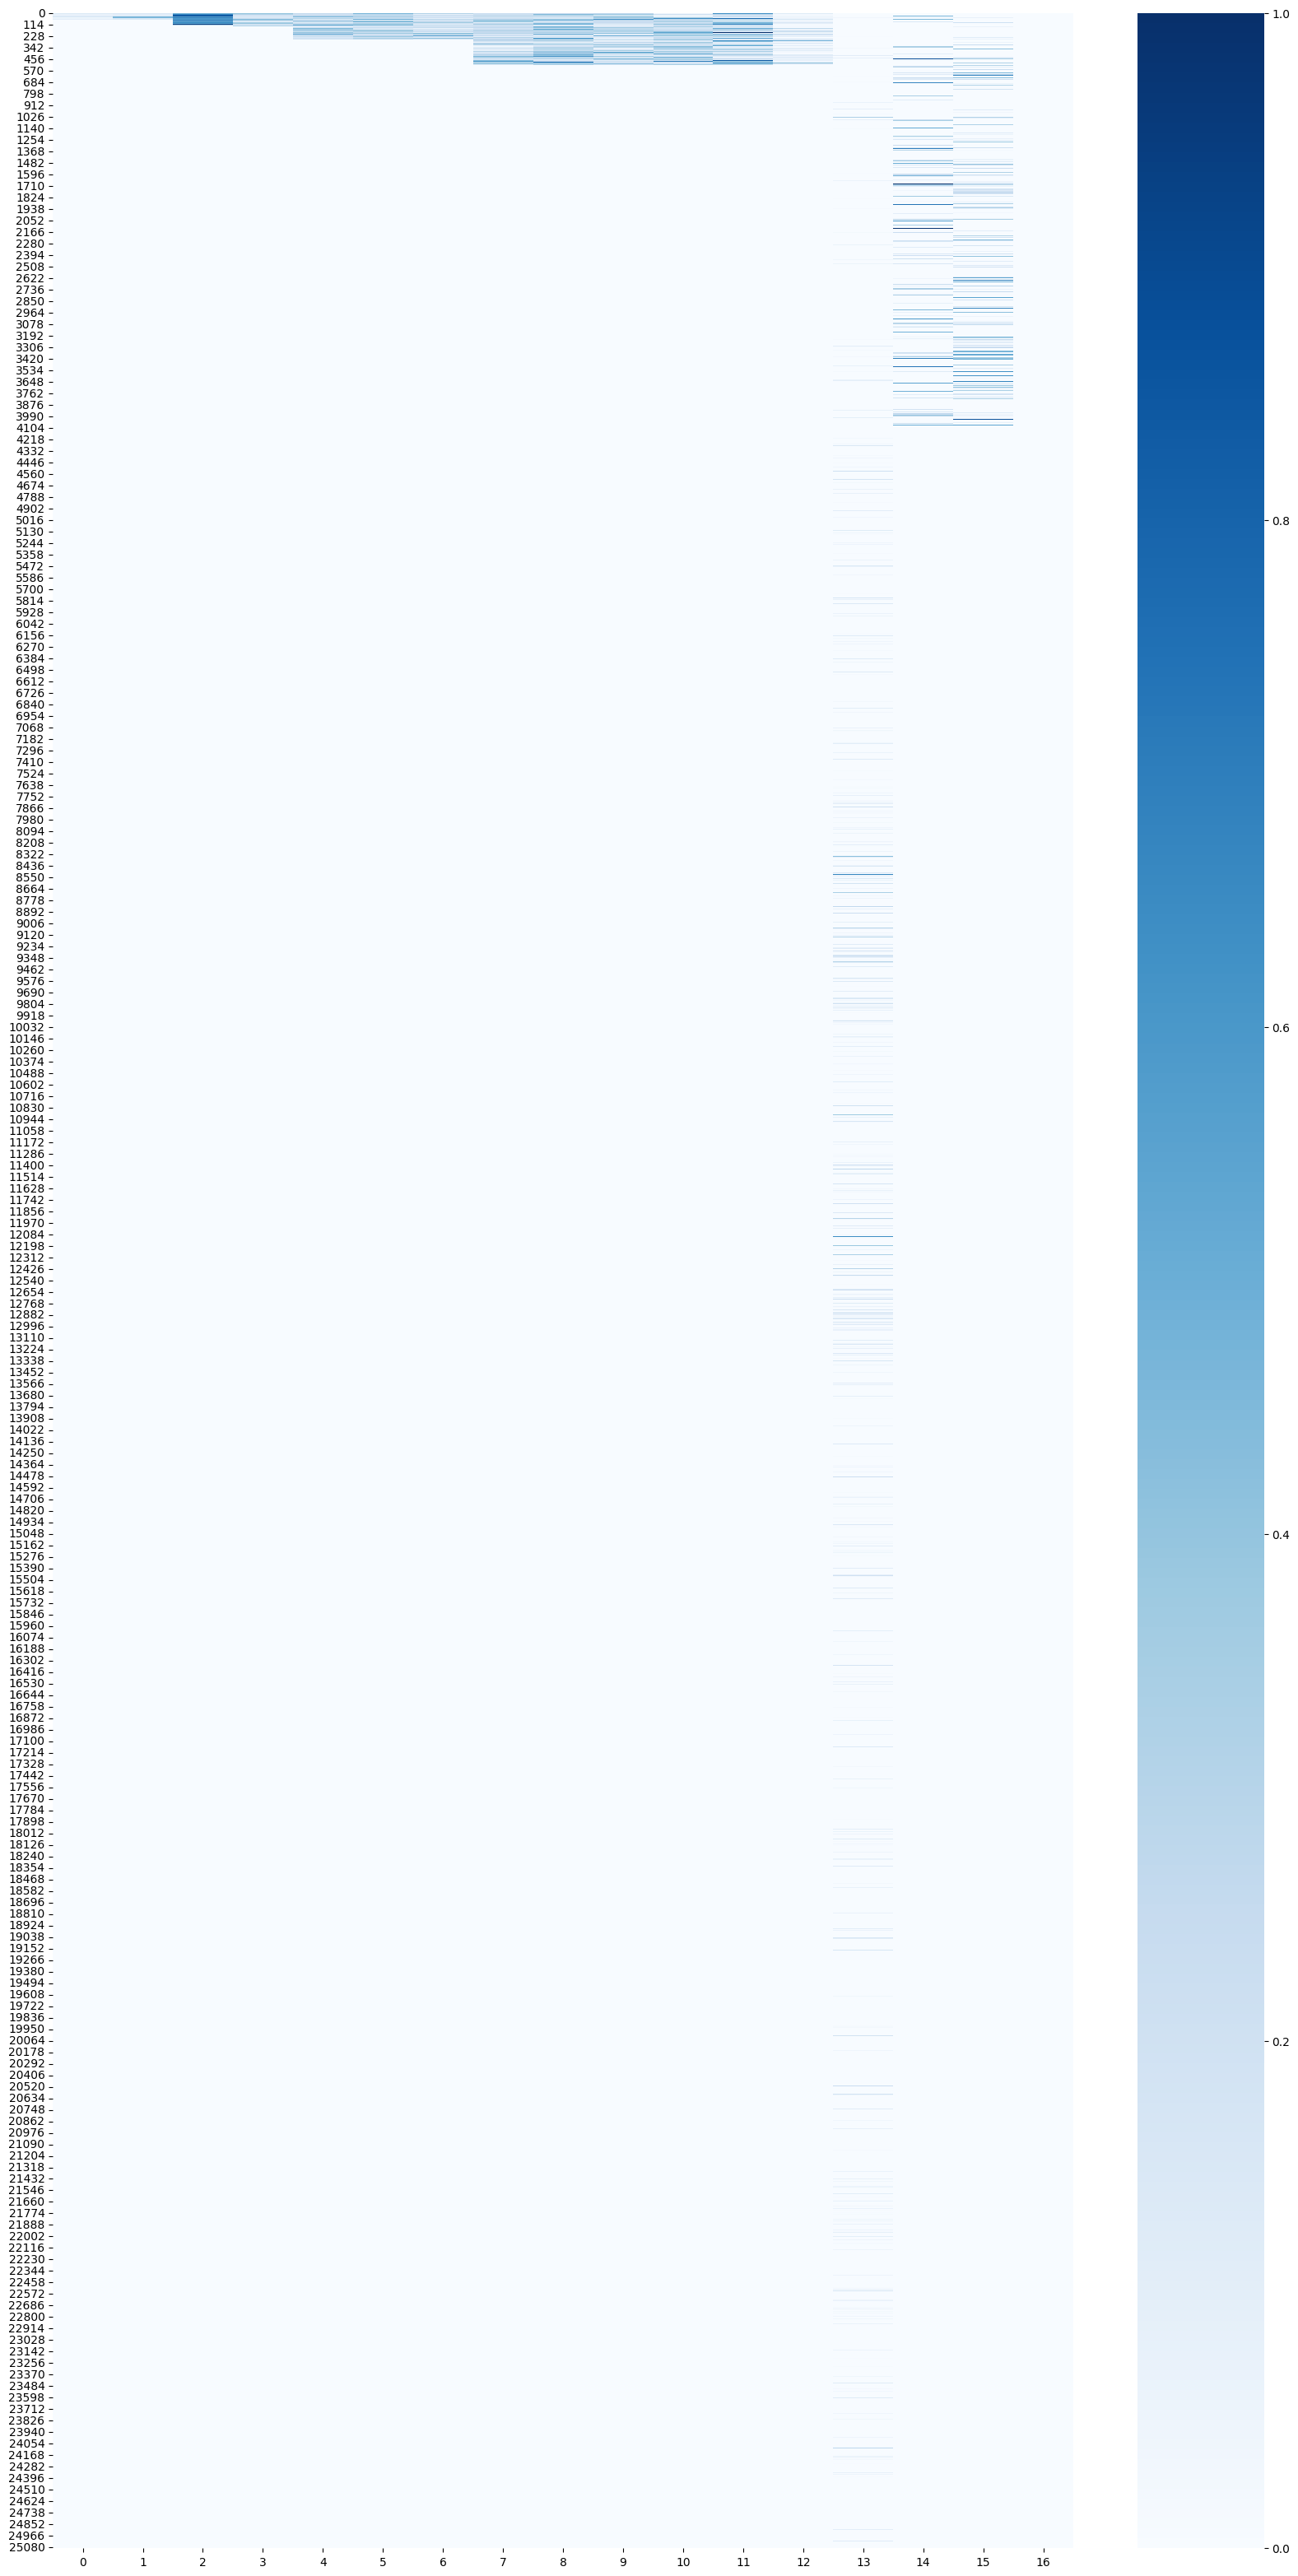

In [49]:
def get_footprint(pathway: dict[str,np.ndarray]):
    max_channels = max([len(layer) for layer in pathway.values()])
    heatmap = np.zeros((max_channels, len(pathway)))
    for i, layer in enumerate(pathway):
        heatmap[:len(pathway[layer]), i] = (pathway[layer] - pathway[layer].min()) / (pathway[layer].max() - pathway[layer].min())
        
    return heatmap
    
heatmap = get_footprint(activationsSummary[0])

fig = plt.figure(figsize=(20, 40))
sns.heatmap(heatmap, cmap='Blues')

# Similar layer activations

In [50]:
class bbox_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.logs = []
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
            self.fig
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)



2023-06-05 12:19:23.022101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1024]
	 [[{{node Placeholder/_2}}]]
2023-06-05 12:19:23.022322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1024]
	 [[{{node Placeholder/_3}}]]


Button(description='Disconnect mpl', style=ButtonStyle())

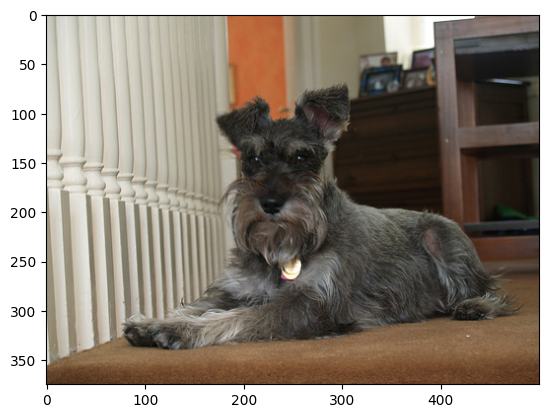

In [70]:
input_img = ds.take(1).as_numpy_iterator().next()[0]

image = ((input_img / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()

bs = bbox_select(input_img)

In [71]:
%matplotlib inline

In [72]:
bs.selected_points

[]

In [73]:
selected_points = [[88.68750000000004, 124.91287878787875],
 [108.08143939393942, 123.09469696969694],
 [111.71780303030307, 107.33712121212119],
 [129.29356060606062, 120.6704545454545],
 [164.4450757575758, 152.18560606060603],
 [141.41477272727275, 165.51893939393938],
 [106.8693181818182, 160.67045454545453],
 [87.47537878787882, 156.42803030303028],
 [74.74810606060608, 134.00378787878785],
 [86.2632575757576, 114.00378787878785]]

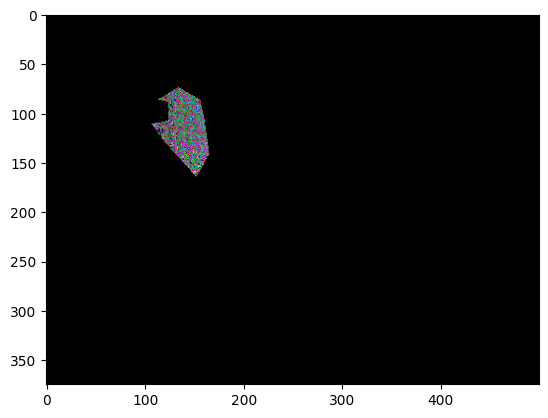

In [85]:
def is_numpy_type(value):
    return hasattr(value, 'dtype')

def apply_mask(img, mask_img):
    if len(img.shape) == 4:
        return np.multiply(img, mask_img[np.newaxis,:,:,np.newaxis])
    elif len(img.shape) == 3:
        return np.multiply(img, mask_img[:,:,np.newaxis])
    elif len(img.shape) == 2:
        return np.multiply(img, mask_img[:,:])
    raise Exception
    
    
def apply_polygon_mask(image, polygon):
    mask = Image.new("L", (image.shape[0], image.shape[1]), 0)
    draw = ImageDraw.Draw(mask)

    polygon_points = [(p[0].item() if is_numpy_type(p[0]) else p[0], p[1].item() if is_numpy_type(p[1]) else p[1]) for p in polygon]
    draw.polygon(polygon_points, outline=1, fill=1)

    mask_array = np.array(mask).T

    return apply_mask(image, mask_array), mask_array

masked_img, mask_img = apply_polygon_mask(image, selected_points)
plt.imshow(masked_img)

In [86]:
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1',
          'block3_conv2',
          'block3_conv3',
          'block4_conv1',
          'block4_conv2',
          'block4_conv3',
          'block5_conv1',
          'block5_conv2',
          'block5_conv3',
          ]

    
def get_mask_activation_channels(mask_img, activations, threshold_fn=lambda layer, channel: channel>10):
    masked_activations = {layer:[] for layer in activations}
    activated_channels = {layer:[] for layer in masked_activations}
    for layer, val in activations.items():
        mask = tf.image.resize(mask_img[:,:,np.newaxis], val.shape[1:3], method=tf.image.ResizeMethod.BILINEAR).numpy().squeeze()
        for channel_i, channel in enumerate(val[0].transpose(2,0,1)):
            masked_val = apply_mask(channel, mask)
            masked_val_summary = summary_fn_image(masked_val[np.newaxis,:,:,np.newaxis]).squeeze()
            masked_activations[layer].append(masked_val_summary.item())
        
        for channel_i, channel in enumerate(masked_activations[layer]):
            if threshold_fn(masked_activations[layer], channel):
                activated_channels[layer].append(channel_i)
    
#     return masked_activations
    return activated_channels

activations = keract.get_activations(model, preprocess(input_img[np.newaxis,:,:,:], None)[0], layer_names=layers)

def thresh_fn(layer, channel):
    return channel > np.percentile(layer, 99)

activated_channels = get_mask_activation_channels(mask_img, activations, thresh_fn)
pprint(activated_channels)
pprint({key:len(val) for key,val in activated_channels.items()})

# heatmap = get_footprint(masked_activations)
# fig = plt.figure(figsize=(20, 40))
# sns.heatmap(heatmap[:,10:], cmap='Blues')

# for (imgs, labels) in tqdm(ds.filter(filter_by_labels).map(preprocess).batch(1).take(5)):
#     cur_activation = keract.get_activations(model, imgs, layer_names=layers)
#     print(cur_activation)
#     break
    
#     activations = convert_activations_to_vals(activations)
#     for i, label in enumerate(labels):
#         label = label.numpy()
#         for layer in layers:
#             cur_pathways[label][layer] += activations[layer][i]

    

{'block1_conv1': [31],
 'block1_conv2': [4],
 'block2_conv1': [41, 82],
 'block2_conv2': [33, 100],
 'block3_conv1': [11, 22, 150],
 'block3_conv2': [61, 161, 206],
 'block3_conv3': [103, 149, 237],
 'block4_conv1': [135, 218, 260, 268, 438, 470],
 'block4_conv2': [7, 212, 243, 425, 475, 481],
 'block4_conv3': [17, 232, 267, 322, 396, 509],
 'block5_conv1': [23, 43, 118, 192, 259, 399],
 'block5_conv2': [17, 106, 134, 257, 346, 361],
 'block5_conv3': [70, 155, 209, 349, 351, 473]}
{'block1_conv1': 1,
 'block1_conv2': 1,
 'block2_conv1': 2,
 'block2_conv2': 2,
 'block3_conv1': 3,
 'block3_conv2': 3,
 'block3_conv3': 3,
 'block4_conv1': 6,
 'block4_conv2': 6,
 'block4_conv3': 6,
 'block5_conv1': 6,
 'block5_conv2': 6,
 'block5_conv3': 6}


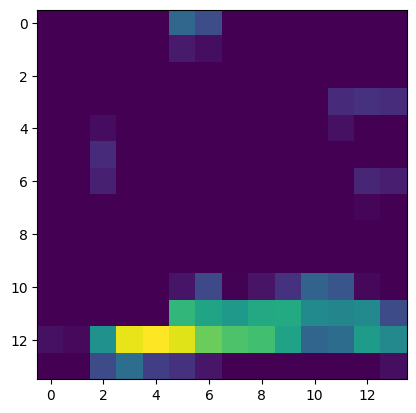

In [87]:
plt.imshow(activations['block5_conv1'][0,:,:,66])

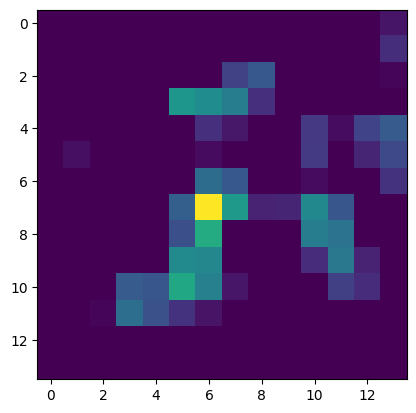

In [88]:
plt.imshow(activations['block5_conv1'][0,:,:,67])

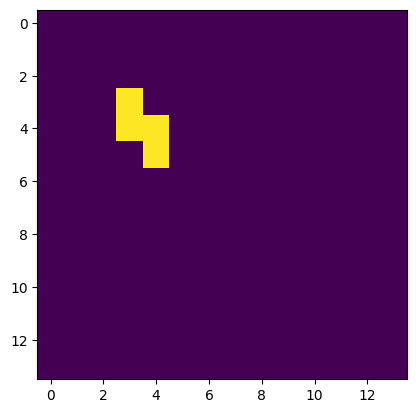

In [89]:
resized_mask = tf.image.resize(mask_img[:,:,np.newaxis], size=activations['block5_conv1'][0,:,:,66].shape, method=tf.image.ResizeMethod.BILINEAR).numpy().squeeze()
plt.imshow(resized_mask)

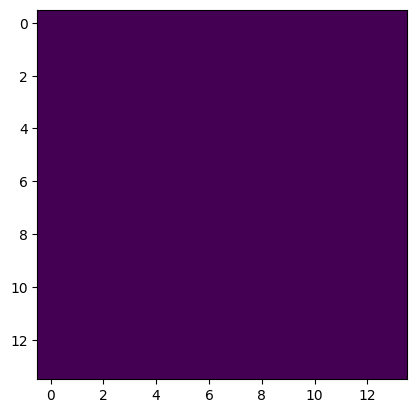

In [90]:
masked_channel = apply_mask(activations['block5_conv1'][0,:,:,67], resized_mask)
plt.imshow(masked_channel)

In [91]:
summary_fn_image(masked_channel[np.newaxis,:,:,np.newaxis]).squeeze()

array(0., dtype=float32)

In [92]:
summary_fn_image(activations['block5_conv1'][0,:,:,67][np.newaxis,:,:,np.newaxis]).squeeze()

array(1190.9447, dtype=float32)

In [93]:
summary_fn_image(apply_mask(activations['block5_conv1'][0,:,:,66], resized_mask)[np.newaxis,:,:,np.newaxis]).squeeze()

array(0., dtype=float32)

In [94]:
summary_fn_image(activations['block5_conv1'][0,:,:,66][np.newaxis,:,:,np.newaxis]).squeeze()

array(1055.7692, dtype=float32)

In [95]:
def subtract_pathways(pathway1, pathway2):
    return {layer: pathway1[layer].squeeze() - pathway2[layer].squeeze() for layer in pathway1}

In [96]:
activations['block1_conv1'].shape

(1, 224, 224, 64)

Text(0.5, 1.0, 'Example input Activation of block5_conv1')

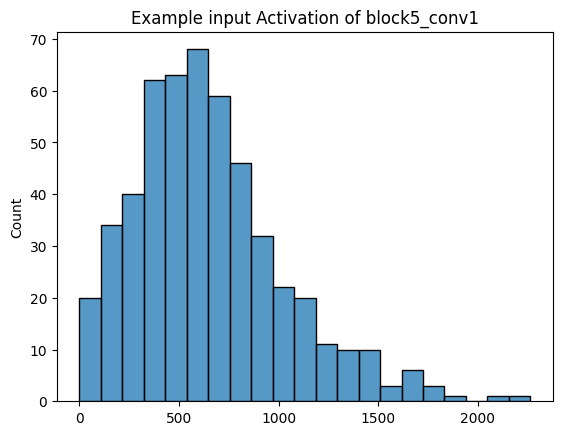

In [97]:
sns.histplot(summary_fn_image(activations['block5_conv1'])[0])
plt.title('Example input Activation of block5_conv1')

/tmp/ipykernel_171999/3195931292.py:10: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap.T / heatmap.T.sum(axis=0)


<Axes: >

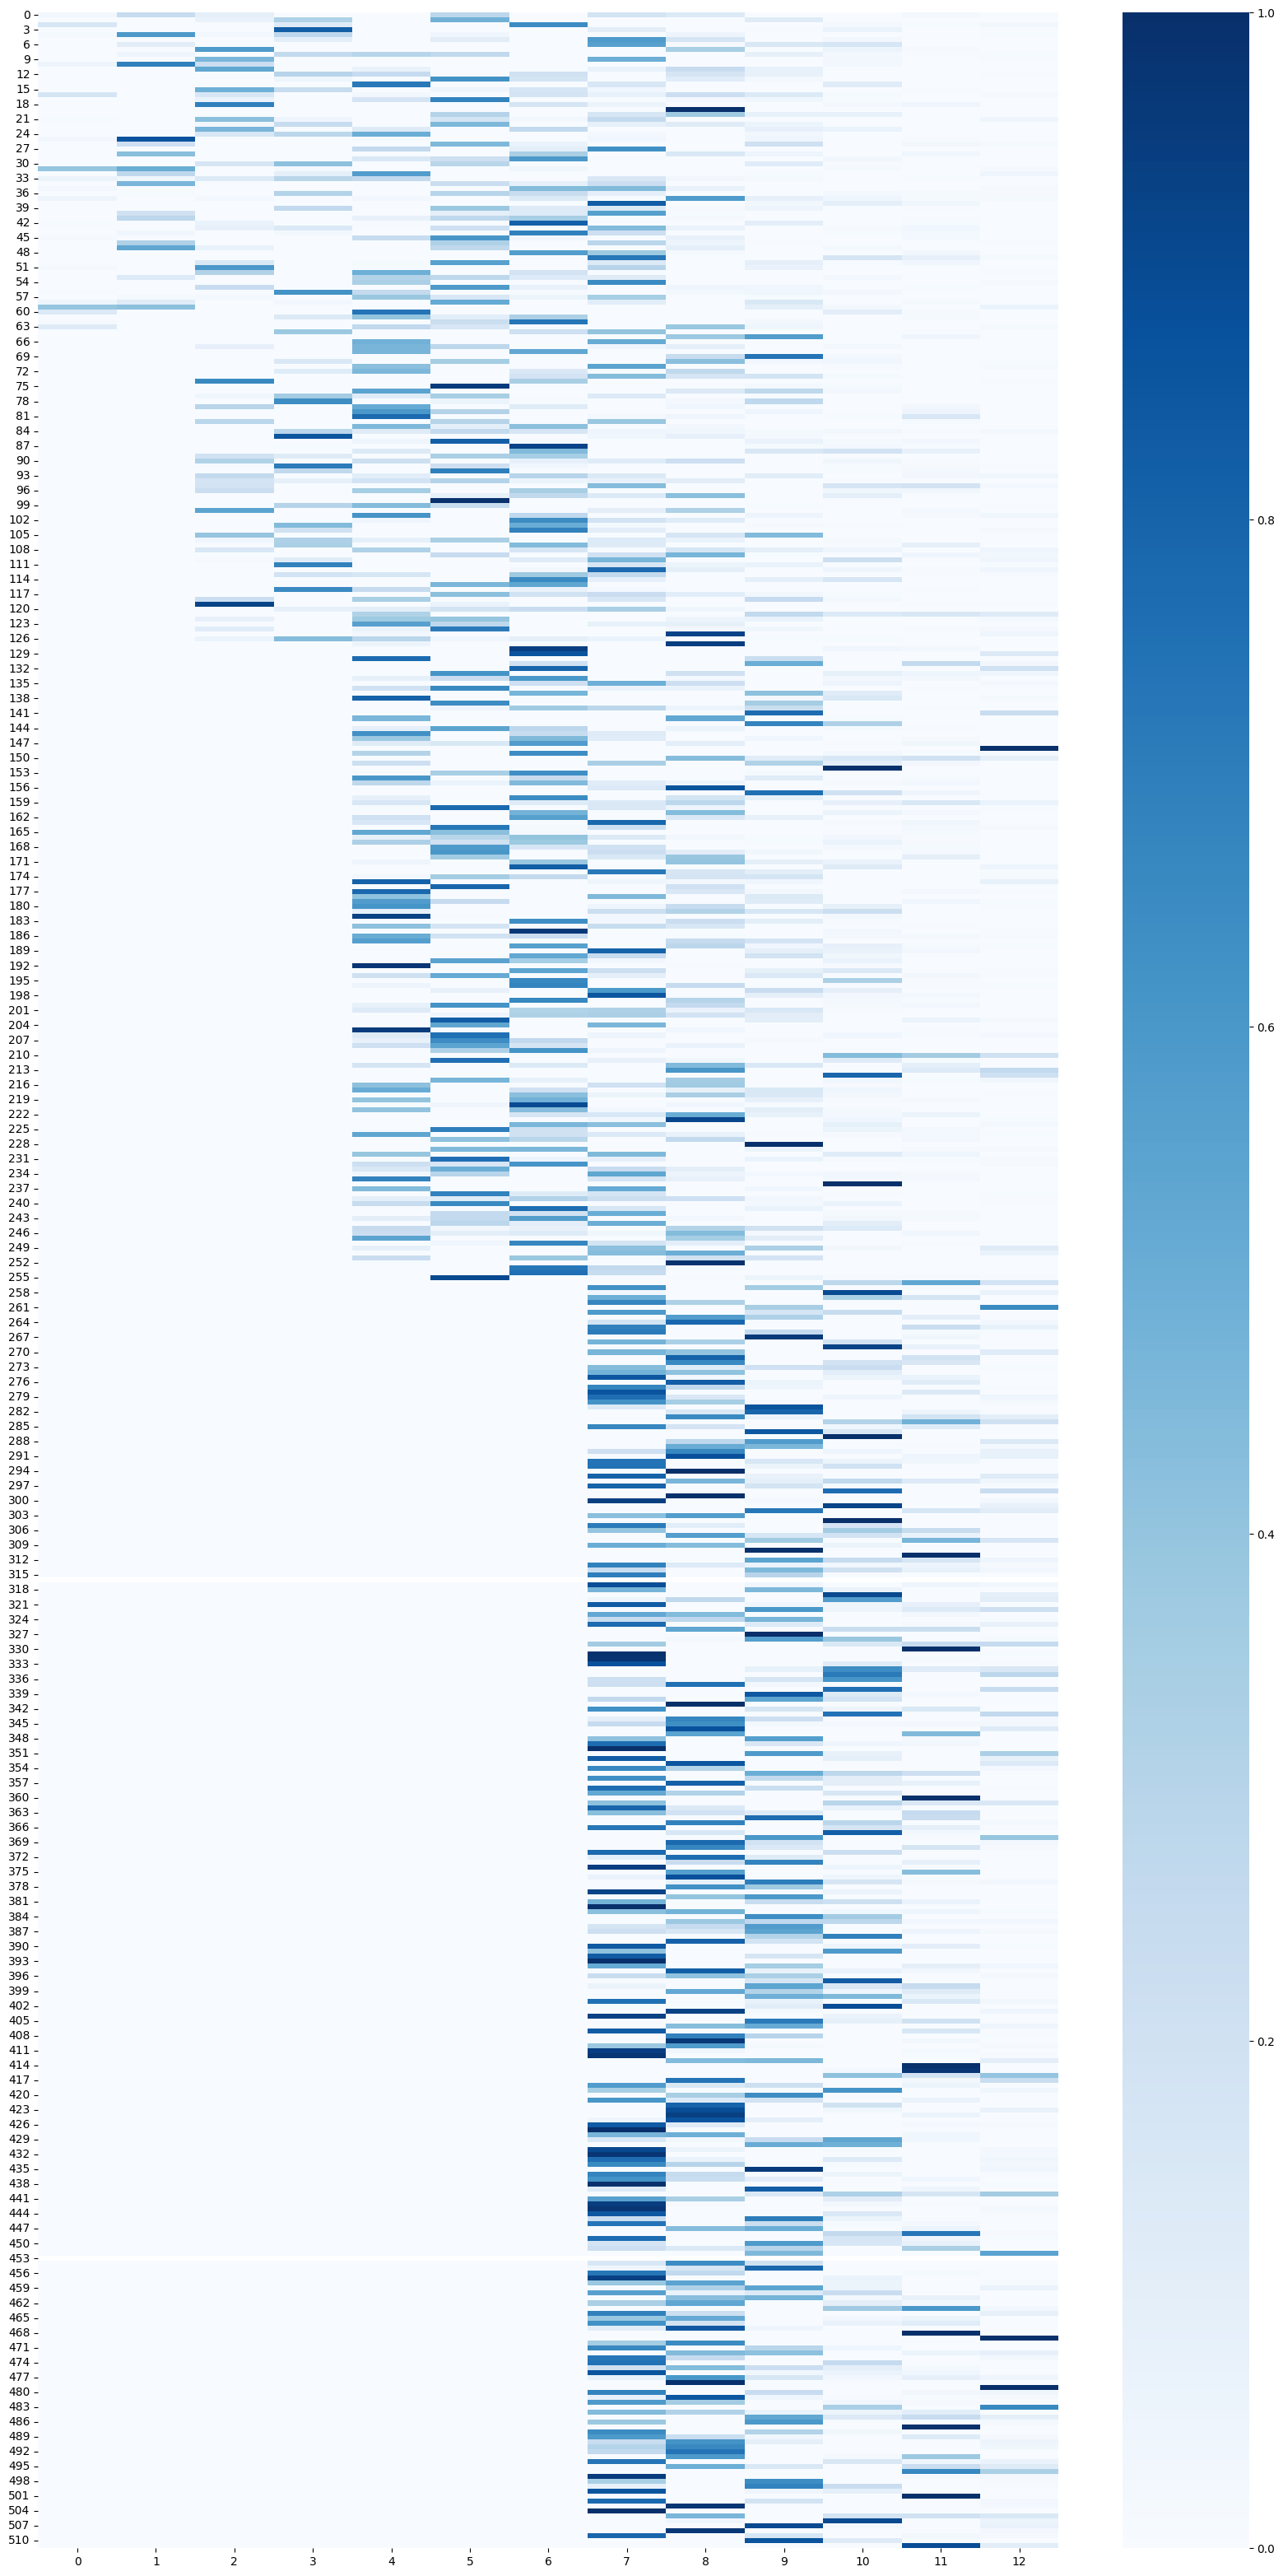

In [83]:
sub_activations = subtract_pathways(activations_l2, pathways[0])
for layer in sub_activations:
    for i, channel in enumerate(sub_activations[layer]):
        if channel < 0:
            sub_activations[layer][i] = 0
            
        
heatmap= get_footprint(sub_activations)
# row wise normalization
heatmap = heatmap.T / heatmap.T.sum(axis=0)
heatmap = heatmap.T

fig = plt.figure(figsize=(20, 40))
sns.heatmap(heatmap, cmap='Blues')

# Calcualte average activation pathway for each class
After that, subtract the class activation pathway from individual activation pathway and visualize the difference.

In [101]:
images = ds.take(1).as_numpy_iterator().next()[0]
input_img1 = images[17]
input_img2 = images[10]
input_img1 = ((input_img1 / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()
input_img2 = ((input_img2 / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()

activations1 = keract.get_activations(model, input_img1[np.newaxis,:,:,:], layer_names=layers)
activations2 = keract.get_activations(model, input_img2[np.newaxis,:,:,:], layer_names=layers)

activation_summary1 = convert_activations_to_vals(activations1)
activation_summary2 = convert_activations_to_vals(activations2)

sub_activation1 = subtract_pathways(activation_summary1, pathways[1])
sub_activation2 = subtract_pathways(activation_summary2, pathways[1])


# for layer in sub_activation1:
#     for i, channel in enumerate(sub_activation1[layer]):
#         if channel < 0:
#             sub_activation1[layer][i] = 0

# for layer in sub_activation2:
#     for i, channel in enumerate(sub_activation2[layer]):
#         if channel < 0:
#             sub_activation2[layer][i] = 0
            
heatmap1 = get_footprint(sub_activation1)
heatmap1 = heatmap1.T / heatmap1.T.sum(axis=0)
heatmap1 = heatmap1.T

heatmap2 = get_footprint(sub_activation2)
heatmap2 = heatmap2.T / heatmap2.T.sum(axis=0)
heatmap2 = heatmap2.T


sns.heatmap(heatmap1, cmap='Blues')
sns.heatmap(heatmap2, cmap='Blues')

2023-06-05 12:25:31.135151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1024]
	 [[{{node Placeholder/_1}}]]
2023-06-05 12:25:31.135443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1024]
	 [[{{node Placeholder/_4}}]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

# Check whether edge weights have visual correlation with the activation channels

In [12]:
kernel_norms = {}
for layer_id, layer_data in simple_activation_pathway_full.nodes(data=True):
    if layer_data['layer_type'] in ['Concatenate', 'InputLayer', 'Dense']:
        continue
    layer_name = layer_data['name']
    kernel = model.get_layer(layer_name).get_weights()
    kernel_norm = np.linalg.norm(kernel[0], axis=(0,1), ord=2).sum(axis=0)
    kernel_norms[layer_name] = kernel_norm.tolist()
    

<Axes: >

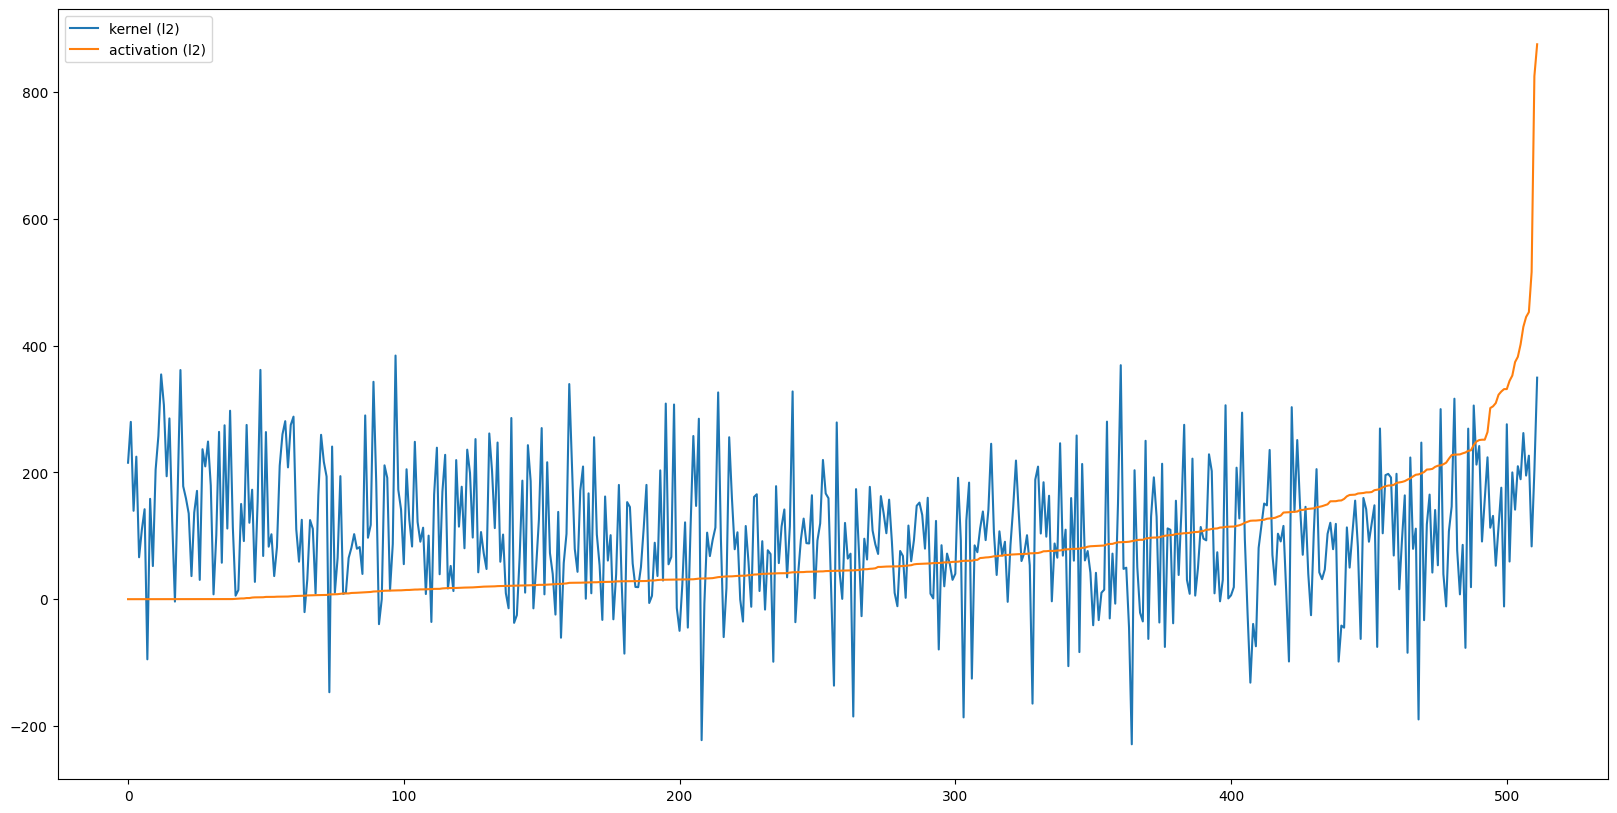

In [14]:
kernel_order = np.argsort(activationsSummary[0]['block5_conv3'])
sorted_actSummary = activationsSummary[0]['block5_conv3'][kernel_order]
sorted_kernel_norms = np.array(kernel_norms['block5_conv3'])[kernel_order]

plt.figure(figsize=(20,10))
sns.lineplot(sorted_kernel_norms*100 - 1000, label='kernel (l2)')
sns.lineplot(sorted_actSummary, label='activation (l2)')

In [47]:
vars = np.stack([sorted_actSummary, sorted_kernel_norms], axis=0)

print('covariance matrix', np.cov(vars)[0][1])
print('correlation matrix', np.corrcoef(vars)[0][1])
corr, _ = pearsonr(sorted_actSummary, sorted_kernel_norms)
print('pearson correlation', corr)
corr, _ = spearmanr(sorted_actSummary, sorted_kernel_norms)
print('Spearmans correlation: %.3f' % corr)

covariance matrix 5.6154281849385
correlation matrix 0.056517124976172214
pearson correlation 0.056517124976172194
Spearmans correlation: -0.095
